# HW4: Bias and GANs


Designed by Maan Qraitem drawing from prior work by Anil Kag, Samarth Mishra, Kun He, Xide Xia, Kubra Cilingir, Vijay Thakkar, Ali Siahkamari, and Brian Kulis.


This assignment will introduce you to 

1. Understanding Spurious Bias and its impact on Model Performance [40 points]

2. Implementing Domain-Independance: A method to mitigate Spurious Bias [40 Points]

3. Introduce Generative Adversarial Learning building blocks. [40 points]

4. Use above blocks to change hairstyles of popular celebrities available in the CelebA dataset. [60 points]

**NOTE** : Problem 3 and 4 are time consuming, not just from code perspective but it takes some effort in training to get reasonable GAN performance (you should expect the training to take roughly 10 hours or more depending on the complexity you choose), so **PLEASE START EARLY.**

## Preamble

We recommend using GPU as the primary compute for these problems. For the first two tasks, we do not expect you to require too much GPU compute time (efficient code should finish within 20mins on a GPU like K80). For the GAN problems, we expect longer run time (specially the problem 4 should take more than 6 hours to get a reasonable generator).

## Environment setup

We provide you the datasets required for this assignment as shared folders in both SCC (`'/projectnb/dl523/materials/datasets/'`) and [Google Drive](https://drive.google.com/drive/folders/1EFJKm8mZk6GPrN2BRuadL_HRg0STb7V0?usp=sharing).


Below we describe the environment setup steps depending on your preferrence. Through [(SCC)](https://www.bu.edu/tech/support/research/computing-resources/scc/) you can get access to GPU compute, below we describe the steps for setting up a tunnel so that you can open a Jupyter notebook on your end.

If you intend to use Google colab, feel free to skip the below steps. Remember, Google colab only provides you a preemptive access to a GPU, so technically you could loose access to a GPU in the middle of your experiments. Ideally, it will allow you access to a GPU for 12 hours (free quota). Also, since its a shared resource, be respectful of the Google colab usage policy. 

## SCC Configuration

For this assignment, we recommend that you use the shared computing cluster [(SCC)](https://www.bu.edu/tech/support/research/computing-resources/scc/). Each of you has an account on the SCC and can login using (more info on the [quick start guide](https://www.bu.edu/tech/support/research/system-usage/scc-quickstart/)):
```
ssh <bu_loginname>@scc1.bu.edu
```

[comment]: #   ( Copy `HW4_datasets.zip` to the SCC, extract and change working directory to the extracted folder. )

Here, we provide some instructions to start a jupyter notebook or jupyter lab server on the SCC. More detailed instructions can be found on the SCC's info website (linked above). These instructions are also fairly easy to find with a google search.
You can then request an interactive session on a compute node using:
```
qrsh -pe omp <num_cpu_cores> -l gpus=<num_gpus_per_cpu_core> -l gpu_c=<gpu_compute_capacity>
```
Recommended values for the parameters in <> above are 2, 1 and 3.5 repectively, which will assign you 2 cpu cores, 1 gpu of compute capacity at least 3.5 for an interactive session of 12 hours. We also have access to some GPUs with compute capacity 6.0 (but they may be somewhat limited in numbers), if you want to explore these GPUs, feel free to request with gpu_c=6.0. 

Now that you are on a compute node, you can load modules you need as:
```
module load cuda/10.1
module load python3/3.6.9
module load pytorch/1.3
```
Running a jupyter server (you can replace the following with `jupyter notebook` for the old interface):
```
jupyter lab --no-browser --ip=0.0.0.0 --port=8888
```
To access the jupyter interface on a browser on your personal machine, use ssh port forwarding as,
```
ssh -N -f -L 8889:<scc-compute-node>:8888 <bu_loginname>@scc1.bu.edu
```
where `<scc_compute_node>` is the compute node on the scc that you have access to through your interactive session (e.g. `scc-k02`). Open a browser and the interface should be accessible at `localhost:8889`. The ports `8888` and `8889` can be changed for something else. If these ports are already in use, feel free to use unused port numbers in the above command.

### Assignment Shared Data path

If you are using your local machine or SSC, please update the python variable `EXPERIMENTS_DIRECTORY` and `DATA_DIR`, prepopulated below to the correct folder where you have stored the files provided for this assignment.

Note that 
1. `EXPERIMENTS_DIRECTORY` : refers to the folder where your experiment results, models, logs and the sample generated will be stored. Please update the path to a folder you have write access. For SCC, it is recommended that you create a folder, ` '/projectnb/dl523/students/<USER-NAME>/experiments'`, change `<USER-NAME>` to your scc username. For Google colab, use any folder you have write access.

2. `DATA_DIR` : refers to the folder where the datasets required for this assignment are stored (For scc, I've already copied the datasets to a folder ( `'/projectnb/dl523/materials/datasets/'` ) where everyone has read accesss. For Google colab, I've shared the dataset at the following directory, `https://drive.google.com/drive/folders/1EFJKm8mZk6GPrN2BRuadL_HRg0STb7V0?usp=sharing`, please update this variable according the path that your BU Google drive account shows. )

## Google Colab Configuration

No special setup is required (just ensure that the runtime is setup to utilize a GPU).

### Assignment Shared Data path

If you are using Google Colab for the experiments, it is easy to link your BU google drive account for storage purposes.

1. First step is to give access permissions to the google colab. Following commands perform the authentication (run these two lines of code, it'll provide you the link for authentication, copy & paste the authorization code in the fill in box provided by the script.)
```
from google.colab import drive
drive.mount('/content/gdrive')
```

2. Finding the right folder path for experiments. Similar to the ```ls``` command in linux, the following command lists the content of the drive (use this to choose your base experiment directory)
```
ls "/content/gdrive/My Drive"
```

3. Please copy all the data provided for this assignment  to the experiment directory, say in the location ```"/content/gdrive/My Drive/Experiments-Deep-Learning-HW4"``` (If you change the path, please update the same in the script below.)
```
ls "/content/gdrive/My Drive/Experiments-Deep-Learning-HW4"
```


In [ ]:
from os import path

# Change this part to locate the correct directory where dataset resides
use_colab = True

if use_colab:
    # from google.colab import drive
    # drive.mount('/content/gdrive')
    #!ls "/content/gdrive/My Drive/Datasets/shared/HW4_shared_files"

    ## Update the experiments directory
    EXPERIMENTS_DIRECTORY = '/content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/'
    DATA_DIRECTORY = '/content/drive/MyDrive/Common Data/CS523/hw4/'
else:
    ## Update the experiments directory
    EXPERIMENTS_DIRECTORY = '/projectnb/dl523/students/mqraitem/experiments'
    DATA_DIRECTORY = '/projectnb/dl523/students/mqraitem/datasets/'

CELEBA_GOOGLE_DRIVE_PATH = path.join(DATA_DIRECTORY, 'celeba_attributes_images.hdf5')
IMDB_REVIEWS_FILE_PATH = path.join(DATA_DIRECTORY, 'data/')

def check_gpu() -> None:
    result = !nvidia-smi --query-gpu=name --format=csv,noheader
    answer = result[0].strip()
    if len(answer) == 0 or "nvidia-smi" in (answer.lower()):
        print("No gpus are found in this Notebook.")
    else:
        print(f"You are using: {answer}")

check_gpu()

You are using: Tesla V100-SXM2-16GB


In [ ]:
def DPATH(f: str) -> str:
    from os.path import join
    return join(EXPERIMENTS_DIRECTORY, f)

### Modules needed

In [ ]:
import os
import random
import math
import datetime
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
#import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from torch.utils import data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchvision import transforms as T
from torchvision.datasets import ImageFolder
from torch.autograd import Variable
from torchvision.utils import save_image
from torch.backends import cudnn

import numpy as np 
from PIL import Image
from tqdm.notebook import tqdm 
import random 

import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch import nn, optim

import typing

%matplotlib inline

# Set random seed for reproducibility
manualSeed = 999
# manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
np.random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


###Q1.1 : Survery of Bias in Deep Learning [10 Points]

Bias in Deep Learning can manifest in many ways. Start by reading the following [Survey](https://arxiv.org/pdf/1908.08843.pdf) . Upon reading, please answer the questions below: 


1. Given a sensitive group of samples (eg a certain class of people), can a deep learning model learn to discriminate against said group if we do not explicitly feed identifying information to the model (ex class indicator variable, zip code, etc)? Support your argument with an example. 

  Yes. For example, a DNN can learn representative of raw texts, which is related to the gender of the user. Although users have never actively-reported their gender (thus, there's no such `gender` label), DNN can still find the distribution differences of texts and sentences produced by people of different genders.
 


2. What is the disadvantage of post-processing methods that calibrate prediction scores to fit a certain fairness metric? discuss this disadvantage in the context of deep learning applications. 

  They require inference-time access to protected attributes, which however usually are not available during inference time in real-world applications. For example, during training and validating in a gender-related program, we can use the existing gender field to mitigate the classifier's relying on the hair style in the picture to predict the gender of a person. However during the predicting stage in production environment (i.e. when program used by the end user), the program will have no chance to get the protected attribute.

In this problem, we will study one form of Bias, usually called: Spurious Correlations. We will explore this bias implication on model performance using a visual recognition problem *. More concretely, given a standard visual recognition dataset with image-target pairs $(X, Y)$ assume that each $x\in X$ can also be classified into a sensitive group $b \in B$. For example, $B$ can represent the various colors of an object or the material it is made of. Bias research is concerned with the scenario when most samples of one class (e.g., airplane) belong to one sensitive group (e.g., objects with the color red). Therefore, the model might use this signal (most airplanes are red) in predicting airplanes. This means the model might be less likely to predict an airplane if it was of the color blue. If your goal for your model is to recognize airplanes of all colors equally well, then the behavior above is suboptimal. 

In this problem, we will use the CIFAR10 dataset to document the occurrence of such Bias. Then, we will experiment with a simple baseline that mitigates it. 

\* Note that this form of Bias can affect more than visual recognition. Examples include Image captioning, VQA, and others.

In [ ]:
class BiasedCifar10: 
    def __init__(self,
                 root,
                 split,
                 skew_value=0.5): 
        
        train_valid = (split == 'train' or split == 'valid')

        # 使用下载好的 cifar 数据集
        self.cifar10 = CIFAR10(root, train=train_valid, download=True)
        self.images = self.cifar10.data 
        self.targets = np.array(self.cifar10.targets) 
        self.bias = np.zeros_like(self.targets) 
        self.split = split
        self.gray_classes =  [0,1,2,3,4]


        mean = [0.4914, 0.4822, 0.4465]
        std = [0.2470, 0.2435, 0.2616]
        self.transform =  transforms.Compose([
                          transforms.ToPILImage(), 
                          transforms.RandomCrop(32, padding=4),
                          transforms.RandomHorizontalFlip(),
                          transforms.ToTensor(),
                          transforms.Normalize(mean, std)])

        if train_valid: 
            self.build_split() 
            self.corrupt_dataset(skew_value)    

        else: 
            self.corrupt_dataset(0.5)
                          
    def build_split(self):
        
        indices = {i:[] for i in range(10)} 
        size_per_class = 5000
        for idx, tar in enumerate(self.targets): 
            indices[tar].append(idx)

        if self.split == 'train': 
            start = 0 
            end = int(size_per_class * 0.9) 

        if self.split == 'valid':
            start = int(size_per_class * 0.9) 
            end = size_per_class

        final_indices = [] 
        for ind_group in indices.values(): 
            final_indices.extend(ind_group[start:end]) 
        
        random.shuffle(final_indices) 
        
        self.images = self.images[final_indices]
        self.bias = self.bias[final_indices]
        self.targets = self.targets[final_indices] 
        
    def rgb_to_grayscale(self, img):
        """Convert image to gray scale"""
        
        pil_img = Image.fromarray(img)
        pil_gray_img = pil_img.convert('L')
        np_gray_img = np.array(pil_gray_img, dtype=np.uint8)
        np_gray_img = np.dstack([np_gray_img, np_gray_img, np_gray_img])
    
        return np_gray_img

    def corrupt_dataset(self, skew_level):
        
        samples_by_class = {i:[] for i in range(10)} 
        for idx, target in enumerate(self.targets): 
            samples_by_class[target].append(idx) 

        for class_idx in tqdm(range(10), desc="Processing classes", unit="cls"): 
            class_samples = samples_by_class[class_idx]
            if class_idx in self.gray_classes: 
                samples_skew_num = int(len(class_samples) * skew_level) 
            else: 
                samples_skew_num = int(len(class_samples) * (1 - skew_level)) 
                
            samples_skew = random.sample(class_samples, samples_skew_num)
            for sample_idx in samples_skew: 
                self.images[sample_idx] = self.rgb_to_grayscale(self.images[sample_idx]) 
                self.bias[sample_idx] = 1 
    
    def __len__(self): 
        return len(self.images) 

    def __getitem__(self, index): 
        img = self.images[index]
        target = self.targets[index]
        bias = self.bias[index]
    
        if self.transform: 
            img = self.transform(img)
        
        return img, target, bias

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torch 

from torchvision.models import resnet18


class FCResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        model = resnet18(pretrained=False)
        modules = list(model.children())[:-1]
        self.extractor = nn.Sequential(*modules)
        self.embed_size = 512
        self.num_classes = num_classes
        self.fc = nn.Linear(self.embed_size, num_classes)

    def forward(self, x):
        out = self.extractor(x)
        out = out.squeeze(-1).squeeze(-1)

        logits = self.fc(out)
        return logits

In [ ]:
skew_value = 0.85
batch_size = 128

ds_train = BiasedCifar10(root='./', split='train', skew_value=skew_value) 
ds_val = BiasedCifar10(root='./', split='valid', skew_value=skew_value) 
ds_test = BiasedCifar10(root='./', split='test') 


train_loader = torch.utils.data.DataLoader(ds_train, batch_size=batch_size,
                                              shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(ds_train, batch_size=batch_size,
                                              shuffle=True, num_workers=2)


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./


Processing classes:   0%|          | 0/10 [00:00<?, ?cls/s]

Files already downloaded and verified


Processing classes:   0%|          | 0/10 [00:00<?, ?cls/s]

Files already downloaded and verified


Processing classes:   0%|          | 0/10 [00:00<?, ?cls/s]

 As discussed earlier, we will work with CIFAR10 dataset. The dataset comes equipped with 10 classes. The dataset code above introduces bias by converting a $S\%$ of the images in the first 5 classes to Gray-Scale. For the rest of the 5 classes, it will convert $1 - S\%$ of them to Gray-Scale. Assuming $S > 50\%$, the first 5 classes will be biased toward Gray, and the rest will be biased toward Color. Thus, $B = \{\text{Color}, \text{Gray-Scale}\}$. You can control the variable $S$ through the skew_value above. To get you started, run the training code below.

In [ ]:
model = FCResNet18(num_classes=10).cuda()
criterion = nn.CrossEntropyLoss()
decay_epochs = [10, 15, 20]

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum =0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=decay_epochs, gamma=0.1)

Epochs = 25

for epoch in range(1, Epochs + 1):
    model.train()

    train_iter = iter(train_loader)
    loss_acc = 0 
    for idx, (images, labels, biases) in enumerate(train_iter):
        labels, biases = labels.cuda(), biases.cuda()

        images = images.cuda()
        logits = model(images)

        loss = criterion(logits, labels)
        loss_acc += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_acc /= Epochs
    print('Epoch %d: Loss = %.2f'%(epoch, loss_acc))

Epoch 1: Loss = 31.00
Epoch 2: Loss = 20.83
Epoch 3: Loss = 18.16
Epoch 4: Loss = 16.39
Epoch 5: Loss = 15.03
Epoch 6: Loss = 14.13
Epoch 7: Loss = 13.37
Epoch 8: Loss = 12.85
Epoch 9: Loss = 12.41
Epoch 10: Loss = 12.12
Epoch 11: Loss = 11.71
Epoch 12: Loss = 11.44
Epoch 13: Loss = 11.33
Epoch 14: Loss = 11.13
Epoch 15: Loss = 10.91
Epoch 16: Loss = 10.80
Epoch 17: Loss = 10.65
Epoch 18: Loss = 10.62
Epoch 19: Loss = 10.34
Epoch 20: Loss = 10.28
Epoch 21: Loss = 10.20
Epoch 22: Loss = 10.16
Epoch 23: Loss = 10.18
Epoch 24: Loss = 9.96
Epoch 25: Loss = 9.97


 As you might have noticed, we only introduce bias to the training set. Therefore, our test set is equally distributed among the bias groups. This choice is because we want to test our model's predictive ability on every bias group. To that end, we will use two metrics. The first one is a standard accuracy metric. The second one is called True Positive Rate Disparity. It seeks to measure the average difference in TPR between the two bias groups for each class. More concretely, it measures: 

$$TD = \frac{1}{C} \sum_{y} | P(\hat{y}=1 | b = 1, y = 1) - P(\hat{y}=1 | b = 0, y = 1)|$$

 Where $C$ indicates the number of classes, $\hat{y}$ indicates model prediction, and $y$ denotes ground-truth label.




### Q1.2 Now, please answer the following questions [10 Points]

1. Why do you think TPR disparity is a good metric to track bias? 

   **Answer:** Because TPR disparity actually represents: for each class, the number of data which should be TP (True Positive), but become others result due to `biased = 1`.

2. What do you think will happen to the Accuracy metric if our test set was not balanced among the bias groups? i.e. it followed the distribution of the training set

   **Answer:** If the distribution of the training set is identical to the training data set, then $P(\hat{y}=1 | b = 1, y = 1)$ will be the same as $P(\hat{y}=1 | b = 0, y = 1)$. This means that the algorithm can no longer measure the value of TPR Disparity.

###Q1.3: Finish the test loop below by writing code to compute accuracy and TPR disparity [10 Points]

In [ ]:
correct = np.zeros((10, 2)) 
counts = np.zeros((10, 2))

with torch.no_grad():
    for idx, (images, labels, biases) in enumerate(tqdm(test_loader)):
        images = images.cuda()
        output = model(images).cpu()
        preds = output.data.max(1, keepdim=True)[1].squeeze(1).numpy()

        true_positive = np.equal(preds, labels.numpy())
        no_biases = (biases.numpy() == 0)
        have_biases = (biases.numpy() == 1)

        for this_label in range(0, 10):
            # Filter the current class label
            these = (labels.numpy() == this_label)
            
            # Count the current class labeled with bias and without bias
            these_no_biases = these & no_biases
            these_have_biases = these & have_biases
            
            counts[this_label, 0] += np.sum(these_no_biases)
            counts[this_label, 1] += np.sum(these_have_biases)

            # current and true
            these_true_no_biases = these_no_biases & true_positive
            these_true_have_biases = these_have_biases & true_positive

            correct[this_label, 0] += np.sum(these_true_no_biases)
            correct[this_label, 1] += np.sum(these_true_have_biases)


final = correct / counts

print("Accuracy %.2f " % np.mean(final))
print("TPR Disparity %.2f " % np.mean(np.abs(final[:, 0] - final[:, 1])))

  0%|          | 0/352 [00:00<?, ?it/s]

Accuracy 0.67 
TPR Disparity 0.28 


In [ ]:
print(f'额外统计信息: final:\n{final}\n correct:\n{correct}\n counts:\n{counts}')

额外统计信息: final:
[[0.72       0.84392157]
 [0.67407407 0.89777778]
 [0.52740741 0.60784314]
 [0.28444444 0.76470588]
 [0.51407407 0.73385621]
 [0.72       0.3037037 ]
 [0.81359477 0.45925926]
 [0.90013072 0.68740741]
 [0.90849673 0.66962963]
 [0.8648366  0.44888889]]
 correct:
[[ 486. 3228.]
 [ 455. 3434.]
 [ 356. 2325.]
 [ 192. 2925.]
 [ 347. 2807.]
 [2754.  205.]
 [3112.  310.]
 [3443.  464.]
 [3475.  452.]
 [3308.  303.]]
 counts:
[[ 675. 3825.]
 [ 675. 3825.]
 [ 675. 3825.]
 [ 675. 3825.]
 [ 675. 3825.]
 [3825.  675.]
 [3825.  675.]
 [3825.  675.]
 [3825.  675.]
 [3825.  675.]]


### Q1.4 Repeat the above training procedure three times using $S \in \{0.85, 0.9, 0.95\}$. Record your TPR and Acc values below and run the code to plot your results. what do you conclude? [10 Points]

In [ ]:
# Wrapping all previous code into functions for easy reuse.


def train_sub(this_train_loader: any) -> any:
    model = FCResNet18(num_classes=10).cuda()
    criterion = nn.CrossEntropyLoss()
    decay_epochs = [10, 15, 20]

    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=decay_epochs, gamma=0.1)

    Epochs = 25

    with tqdm(total=Epochs, desc="Epoch: ") as tqdm1:
        for epoch in range(1, Epochs + 1):
            model.train()

            train_iter = iter(this_train_loader)
            loss_acc = 0 
            for idx, (images, labels, biases) in enumerate(train_iter):
                labels, biases = labels.cuda(), biases.cuda()

                images = images.cuda()
                logits = model(images)

                loss = criterion(logits, labels)
                loss_acc += loss.item()

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            loss_acc /= Epochs
            # print('Epoch %d: Loss = %.2f'%(epoch, loss_acc))
            tqdm1.update()

    return model

def test_sub(this_test_loader: any, model: any):
    correct = np.zeros((10, 2)) 
    counts = np.zeros((10, 2))

    with torch.no_grad():
        for idx, (images, labels, biases) in enumerate(tqdm(this_test_loader)):
            images = images.cuda()
            output = model(images).cpu()
            preds = output.data.max(1, keepdim=True)[1].squeeze(1).numpy()

            true_positive = np.equal(preds, labels.numpy())
            no_biases = (biases.numpy() == 0)
            have_biases = (biases.numpy() == 1)

            for this_label in range(0, 10):
                # Filter the current class label
                these = (labels.numpy() == this_label)
                
                # Count the current class labeled with bias and without bias
                these_no_biases = these & no_biases
                these_have_biases = these & have_biases
                
                counts[this_label, 0] += np.sum(these_no_biases)
                counts[this_label, 1] += np.sum(these_have_biases)

                # current and true
                these_true_no_biases = these_no_biases & true_positive
                these_true_have_biases = these_have_biases & true_positive

                correct[this_label, 0] += np.sum(these_true_no_biases)
                correct[this_label, 1] += np.sum(these_true_have_biases)


    final = correct / counts

    print("Accuracy %.2f " % np.mean(final))
    print("TPR Disparity %.2f " % np.mean(np.abs(final[:, 0] - final[:, 1])))
    # print(f'额外统计信息: final:\n{final}\n correct:\n{correct}\n counts:\n{counts}')


def train_with_skew(skew_prop: float):
    from torch.utils.data import DataLoader

    if skew_prop < 0 or skew_prop > 1:
        raise ValueError("skep_prop should be a float between 0.0 and 1.0")
    
    skew_value = skew_prop
    batch_size = 128

    this_ds_train = BiasedCifar10(root='./', split='train', skew_value=skew_value)

    this_train_loader = DataLoader(this_ds_train, batch_size=batch_size,
                                   shuffle=True, num_workers=2)
    this_test_loader = DataLoader(this_ds_train, batch_size=batch_size,
                                   shuffle=True, num_workers=2)
    
    model = train_sub(this_train_loader)
    test_sub(this_test_loader, model)
        

for skew in [0.85, 0.9, 0.95]:
    print(f"Skew = {skew}")
    train_with_skew(skew)


Skew = 0.85
Files already downloaded and verified


Processing classes:   0%|          | 0/10 [00:00<?, ?cls/s]

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

Accuracy 0.67 
TPR Disparity 0.30 
Skew = 0.9
Files already downloaded and verified


Processing classes:   0%|          | 0/10 [00:00<?, ?cls/s]

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

Accuracy 0.65 
TPR Disparity 0.31 
Skew = 0.95
Files already downloaded and verified


Processing classes:   0%|          | 0/10 [00:00<?, ?cls/s]

Epoch:   0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/352 [00:00<?, ?it/s]

Accuracy 0.59 
TPR Disparity 0.48 


Text(0, 0.5, 'TPR Disparity')

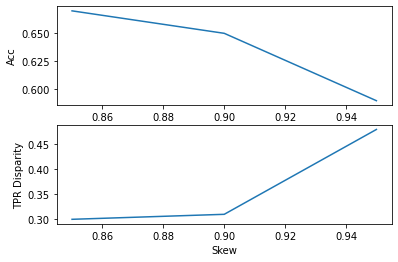

In [ ]:
Skew = [0.85, 0.9, 0.95]

################################################
##### FILL YOUR EXPERIMENTS VALUES HERE
Acc = [0.67, 0.65, 0.59]
TPR = [0.30, 0.31, 0.48] 
################################################


import matplotlib.pyplot as plt

f, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(Skew, Acc)
ax1.set_xlabel('Skew')
ax1.set_ylabel('Acc')

ax2.plot(Skew, TPR)
ax2.set_xlabel('Skew')
ax2.set_ylabel('TPR Disparity')

**Answer:** The higher the rate of bias in each class, the more Accuracy is eventually lost due to bias (i.e., the value of TDR Disparity, which is larger to indicate more loss).
 

### Q2 Mitigating Bias 

In this section of the problem, we will explore Domain Independence, one of many solutions for mitigating Bias. The solution dedicates a prediction head for each different sensitive group $b$. Observe the Figure below. Note that each sensitive group: Color/Gray will have its prediction head of 10 classes. Thus, when training, samples that belong to $b= $Color will backpropagate only through the Color prediction head. 


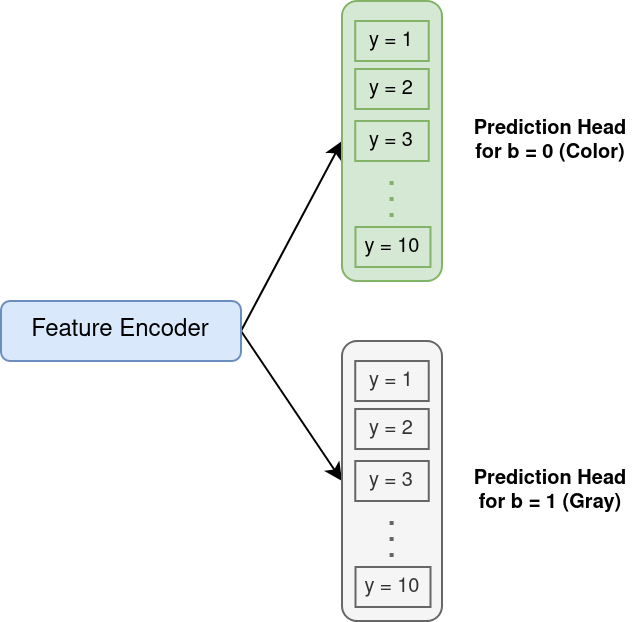

### Q2.1 Why do you think this might be a good solution? [5 Points]

It uses a similarity metric as a feature to compare with labeled domain data. Then the model will learn a matching function to infer the correct semantic label of the data.


###Q2.2: We wrote most of the model structure but we left the final linear layer for you to implement. Fill in the code below: [5 Points]

In [ ]:
class DIResNet18(nn.Module):
    def __init__(self, num_classes=10, num_biases=2):
        super().__init__()

        # Using a pre-trained ResNet 18 network
        model = resnet18(pretrained=False)

        # Remove the last layer of the network
        # and modify it to our custom structure
        modules = list(model.children())[:-1]
        self.extractor = nn.Sequential(*modules)

        # The number of cells that will be output
        # by the last layer of the ResNet network
        self.embed_size = 512
        self.num_classes = num_classes
        self.num_biases = num_biases

        ################################################
        ##### CODE HERE
        self.fc = nn.Linear(self.embed_size,
                            self.num_classes * self.num_biases)
        ################################################ 
                
    def forward(self, x):
        out = self.extractor(x)
        out = out.squeeze(-1).squeeze(-1)
        logits = self.fc(out)
        return logits

###Q2.3: Before we start training, we need to write the loss function.

- [ ] First, you will need to apply softmax for each head independently. 
- [ ] Then, given the bias value for each sample, you will need to select the logit values of that sample from the correct prediction head [20 Points] 

Hint: Consider using Pytorch NLL [implemenation](https://pytorch.org/docs/stable/generated/torch.nn.NLLLoss.html). 

In [ ]:
import pdb

class DILoss(nn.Module):
    def __init__(self,
                 num_classes: int=10,
                 num_biases: int=2):
        super().__init__()
        self.num_classes = num_classes
        self.num_biases = num_biases

    def forward(self, logits: torch.Tensor, labels: torch.Tensor, biases: torch.Tensor):
        # split into different classes

        logits_heads = [logits[:,self.num_classes * i:self.num_classes * (i + 1)] for i in range(self.num_biases)]
        
        logSoftMax = nn.LogSoftmax(dim=1)
        ll_logits_heads = [logSoftMax(logits_heads[i]) for i in range(self.num_biases)]

        # then we will select from this heads
        final_ll_logits = []
        for i, bias in enumerate(biases):
            final_ll_logits.append(ll_logits_heads[bias][i])
        final_ll_logits = torch.stack(final_ll_logits)

        nllLoss = nn.NLLLoss()
        loss = nllLoss(final_ll_logits, labels)
        return loss

### Once you are done with the loss, you can start training the model below. 

In [ ]:
skew_value = 0.95
batch_size = 128

ds_train = BiasedCifar10(root='./', split='train', skew_value=skew_value) 
ds_val = BiasedCifar10(root='./', split='valid', skew_value=skew_value) 
ds_test = BiasedCifar10(root='./', split='test') 


train_loader = torch.utils.data.DataLoader(ds_train, batch_size=batch_size,
                                              shuffle=True, num_workers=2)
val_loader = torch.utils.data.DataLoader(ds_train, batch_size=batch_size,
                                              shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(ds_train, batch_size=batch_size,
                                              shuffle=True, num_workers=2)

Files already downloaded and verified


Processing classes:   0%|          | 0/10 [00:00<?, ?cls/s]

Files already downloaded and verified


Processing classes:   0%|          | 0/10 [00:00<?, ?cls/s]

Files already downloaded and verified


Processing classes:   0%|          | 0/10 [00:00<?, ?cls/s]

In [ ]:
model = DIResNet18().cuda()
criterion = DILoss()
decay_epochs = [10, 15, 20]

optimizer = optim.SGD(model.parameters(), lr=0.1, momentum =0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=decay_epochs, gamma=0.1)

Epochs = 25

for epoch in range(1, Epochs + 1):
    model.train()

    train_iter = iter(train_loader)
    loss_acc = 0 
    for idx, (images, labels, biases) in enumerate(train_iter):
        labels, biases = labels.cuda(), biases.cuda()

        images = images.cuda()
        logits = model(images)

        loss = criterion(logits, labels, biases)
        loss_acc += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_acc /= Epochs
    print('Epoch %d: Loss = %.2f'%(epoch, loss_acc))

Epoch 1: Loss = 24.07
Epoch 2: Loss = 16.84
Epoch 3: Loss = 14.78
Epoch 4: Loss = 13.18
Epoch 5: Loss = 12.18
Epoch 6: Loss = 11.41
Epoch 7: Loss = 10.90
Epoch 8: Loss = 10.46
Epoch 9: Loss = 10.10
Epoch 10: Loss = 9.94
Epoch 11: Loss = 9.67
Epoch 12: Loss = 9.43
Epoch 13: Loss = 9.31
Epoch 14: Loss = 9.05
Epoch 15: Loss = 9.07
Epoch 16: Loss = 8.90
Epoch 17: Loss = 8.79
Epoch 18: Loss = 8.59
Epoch 19: Loss = 8.57
Epoch 20: Loss = 8.61
Epoch 21: Loss = 8.45
Epoch 22: Loss = 8.39
Epoch 23: Loss = 8.29
Epoch 24: Loss = 8.43
Epoch 25: Loss = 8.28


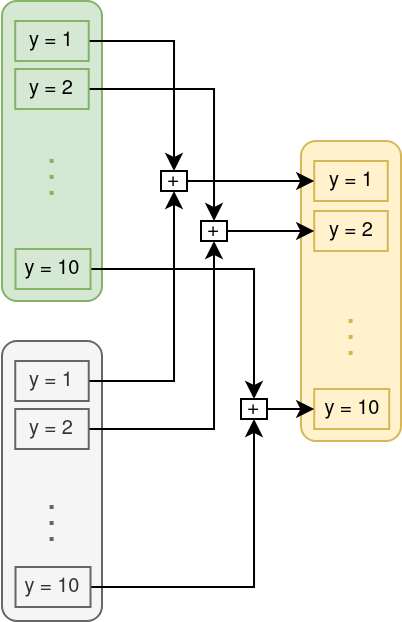

Finally, we will have to do some inference! A significant challenge with this problem is that we don't have access to the bias label at test time. Therefore, we will have to combine the information from each head. It turns out that summing the logits for each class from every head is a good solution, as the figure above suggests. 

###Q2.4: Imeplemnt the inference procedure described above. Have your Unbiased Accuracy and TPR Disparity Improve? [10 Points] 

In [ ]:
correct = np.zeros((10, 2)) 
counts = np.zeros((10, 2))

with torch.no_grad():
    for idx, (images, labels, biases) in enumerate(tqdm(test_loader)):
        images = images.cuda()
    
        ################################################
        ##### TODO CODE HERE

        # output contains 20 output, where 0-9 means bias=0,
        # and 10-19 means bias=1
        output = model(images).cpu()

        # Cumulative prediction results for bias=0 and bias=1
        output2 = output[:,0:10] + output[:,10:20]

        preds = output2.data.max(1, keepdim=True)[1].squeeze(1).numpy()

        true_positive = np.equal(preds, labels.numpy())
        no_biases = (biases.numpy() == 0)
        have_biases = (biases.numpy() == 1)

        for this_label in range(0, 10):
            # Filter the current class label
            these = (labels.numpy() == this_label)
            
            # Count the current class labeled with bias and without bias
            these_no_biases = these & no_biases
            these_have_biases = these & have_biases
            
            counts[this_label, 0] += np.sum(these_no_biases)
            counts[this_label, 1] += np.sum(these_have_biases)

            # current and true
            these_true_no_biases = these_no_biases & true_positive
            these_true_have_biases = these_have_biases & true_positive

            correct[this_label, 0] += np.sum(these_true_no_biases)
            correct[this_label, 1] += np.sum(these_true_have_biases)
        
        ################################################

final = correct/counts
print("Accuracy %.2f "%np.mean(final))
print("TPR Disparity %.2f "%np.mean(np.abs(final[:, 0] - final[:, 1])))

  0%|          | 0/352 [00:00<?, ?it/s]

Accuracy 0.69 
TPR Disparity 0.05 


## Q3 : GAN model on Celeb-A face dataset [40 points]

We will implement a Generative Adversarial Network (GAN) in Q3 and Q4. In this problem, we will start by implementing basic helper functions and a working training routine which would be modified a bit in problem Q4 to present a hairstyle change application. 

This assignment is inspired by the following research paper, 

[StarGAN: Unified Generative Adversarial Networks for Multi-Domain Image-to-Image Translation](https://arxiv.org/abs/1711.09020)

Note that the basic building blocks of GAN are 
1. **Generator** : generates images similar to the real images provided in the dataset in order to fool the discriminator.

2. **Discriminator** : acts as a fact checker in order to determine which images are fake and which are real 

3. **Latent representation** : generator cannot arbitrarily generate images out of thin air. It picks up a latent representation (usually a noise or some fixed pattern), and utilizes this source as a latent code and generates image during this process.

For an easy tutorial to understand GAN's building blocks, please follow the PyTorch DC-GAN [tutorial](https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html). It is recommended you study the tutorial before proceeding with the assignment. 


Note that f and g in the following image are the same as $D$ and $G$ respectively

<img src="https://i.imgur.com/FhSycJD.png" style="width: 600px;"/>

Although the tutorial describes the GAN framework very well with appropriate links to the original paper, for completeness, we mention the losses for the discriminator and generator. The GAN optimization objective is the following : 

$$\underset{G}{\text{min}} ~~ \underset{D}{\text{max}} ~~ V(D,G) = \mathbb{E}_{x\sim p_{x}(x)}\big[\log D(x)\big] + \mathbb{E}_{z\sim p_{z}(z)}\big[\log (1-D(G(z)))\big]$$

where $p_{x}(x)$ is the distribution of the real image data and $p_{z}(z)$ is the distribution from which latent vectors are sampled to input to the generator. $G$ is the generator, parametrized by parameters $w$ and $D$, the discriminator with parameters $\phi$. In practice, these parameters are usually optimized in an alternating fashion, fixing one when optimizing the other, with the following loss functions:

$$ loss_D(\phi) = - \mathbb{E}_{x\sim p_{x}(x)}\big[\log D(x; \phi)\big] - \mathbb{E}_{z\sim p_{z}(z)}\big[\log (1-D(G(z; w); \phi))\big] $$

$$ loss_G(w) = - \mathbb{E}_{z\sim p_{z}(z)}\big[\log (D(G(z; w); \phi))\big] $$

In this assignment you shall use these loss functions and method of training $G$ and $D$.

## StarGAN Architecture (Single dataset)

Above figure is a generic representation of a DC-GAN architecture, although powerful, it will not be able to accuractly generate discrete feature transformations. Instead we use StarGAN, originally proposed to learn feature generators using multiple dataset (uses two large vision datasets (CelebA, RaFD) in the paper). For example in the image below, you see the entire architecture which uses only CelebA dataset, and keeps discards RaFD information. For simplicity, we will use only one dataset, i.e. CelebA. From this architecture, you should takeaway the following points

1. **Discriminator** is learning to distinguish between a real and a fake/generator image. It also learns what the label looked like in the original dataset (we only care about CelebA label).

2. **Generator** is learning to generate a new image from the given input image and the target attribute (for example hairstyle change, in the image below, gender change is requested). 

Note that the attribute or the latent information for the generator is a discrete boolean vector, instead of a Gaussian vector which you generate in GANs like DC-GAN. 

<img src="https://i.imgur.com/58dbEX9.png" style="width: 600px;"/>


### Arguments

First, we first define some arguments for the training run. 

-  **selected_attributes** -  the attributes which will be used for generating various style attributes on the celebrity face.
-  **c_dim** - the number of attributes we will use from the CelebA dataset. its set to `len(selected_attributes)`
-  **image_size** - the spatial size of the images used for training.
   This implementation defaults to 64x64. 
-  **g_conv_dim** - the number of convolutional fitlers for generator
-  **d_conv_dim** - the number of convolutional fitlers for discriminator 
-  **g_repeat_num** - the number of residual blocks in the generator 
-  **d_repeat_num** - the number of residual blocks in the discriminator
-  **lambda_cls** - the regularization hyper-parameter for classification error
-  **lambda_rec** -  the regularization hyper-parameter for reconstruction error
-  **lambda_gp** -  the regularization hyper-parameter for gradient penalty

-  **batch_size** - the batch size used in training. The paper
   uses a batch size of 16 for large configuration
-  **num_iters** - the number of training iterations
   the DataLoader
-  **num_iters_decay** - the number of iterations after which learning rate will decay
-  **g_lr** - the learning rate for generator
-  **d_lr** - the learning rate for discriminator
-  **n_critic** - generator will be updated every n_critic iterations.
-  **beta1** - beta1 hyperparameter for Adam optimizers. As described in
   paper, this number should be 0.5
-  **beta2** - beta2 hyperparameter for Adam optimizers. As described in
   paper, this number should be 0.999
-  **num_workers** - the number of worker threads for loading the data with
   the DataLoader
-  **log_step** - log the update every log_steps
-  **sample_step** - generate a new sample every sample_step
-  **model_save_step** - save the model every model_save_step
-  **lr_update_step** - update the learning rate every lr_update_step
-  **log_dir** - directory where logs are stored
-  **sample_dir** - directory where samples are stored
-  **model_save_dir** - directory where trained models are stored
-  **result_dir** - directory where results are stored



In [ ]:
cudnn.benchmark = True

def get_experiment_configuration(repeat_num=6, num_iters=200000,
              log_step=100, sample_step=100, model_save_step=10000, 
              lr_update_step=1000, batch_size=16, mode='train', resume_iters=False,
              selected_attributes = ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Male', 'Young']):
    config = {}

    # Model configurations.
    config['c_dim'] = len(selected_attributes)
    config['image_size'] = 64
    config['g_conv_dim'] = 64
    config['d_conv_dim'] = 64
    config['g_repeat_num'] = repeat_num
    config['d_repeat_num'] = repeat_num
    config['lambda_cls'] = 1
    config['lambda_rec'] = 10
    config['lambda_gp'] = 10
    config['selected_attributes'] = selected_attributes 

    # Training configurations.
    config['batch_size'] = batch_size #16
    config['num_iters'] = num_iters
    config['num_iters_decay'] = num_iters//2
    config['g_lr'] = 0.0001
    config['d_lr'] = 0.0001
    config['n_critic'] = 5
    config['beta1'] = 0.5
    config['beta2'] = 0.999
    config['resume_iters'] = resume_iters

    # Test configurations.
    config['test_iters'] = num_iters

    # Miscellaneous.
    config['device'] = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    config['num_workers'] = 1
    config['mode'] = mode

    # Step size.
    config['log_step'] = log_step #10
    config['sample_step'] = sample_step
    config['model_save_step'] =  model_save_step #10000
    config['lr_update_step'] = lr_update_step # 1000

    EXPERIMENT_RESULTS_FOLDER = EXPERIMENTS_DIRECTORY + 'gan-experiments/'

    suffix = str(repeat_num) + '-cdim-' + str(len(selected_attributes))
    config['log_dir'] = EXPERIMENT_RESULTS_FOLDER + 'logs-' + suffix
    config['sample_dir'] = EXPERIMENT_RESULTS_FOLDER + 'sample_dir-' + suffix
    config['model_save_dir'] = EXPERIMENT_RESULTS_FOLDER + 'model_save_dir-' + suffix
    config['result_dir'] = EXPERIMENT_RESULTS_FOLDER + 'result_dir-' + suffix

    print('\n\nPlease ensure you are using a GPU for computation')
    print('Will be using the following device for computation : ', config['device'])

    # Create directories if not exist.
    if not os.path.exists(config['log_dir']):
        os.makedirs(config['log_dir'])
    if not os.path.exists(config['sample_dir']):
        os.makedirs(config['sample_dir'])
    if not os.path.exists(config['model_save_dir']):
        os.makedirs(config['model_save_dir'])
    if not os.path.exists(config['result_dir']):
        os.makedirs(config['result_dir'])

    return config

### Data

We have downloaded pre-processed and stored data in the HDF5 format on the zip file provided with the assignment. Think of the file storing a large numpy ndarray of images (shape : `num_imgs x num_channels x height x width`). `celebA` class implemented below derives from `torch.utils.data.Dataset` and provides the code infrastucture to read images from this file. 

This data contains images of many celebrities along with labels for various image attributes (hair, gender, age, etc). There are 40 such attributes. We will use them later for cool applications. 

In [ ]:
ALL_ATTRIBUTES = ['5_o_Clock_Shadow', 'Arched_Eyebrows', 'Attractive',  
      'Bags_Under_Eyes',  'Bald', 'Bangs', 'Big_Lips', 'Big_Nose', 'Black_Hair', 
      'Blond_Hair', 'Blurry', 'Brown_Hair', 'Bushy_Eyebrows', 'Chubby',
      'Double_Chin', 'Eyeglasses', 'Goatee', 'Gray_Hair', 'Heavy_Makeup',
      'High_Cheekbones', 'Male', 'Mouth_Slightly_Open', 'Mustache', 
      'Narrow_Eyes', 'No_Beard', 'Oval_Face', 'Pale_Skin', 'Pointy_Nose', 
      'Receding_Hairline', 'Rosy_Cheeks', 'Sideburns', 'Smiling', 'Straight_Hair',
      'Wavy_Hair', 'Wearing_Earrings', 'Wearing_Hat', 'Wearing_Lipstick',
      'Wearing_Necklace', 'Wearing_Necktie', 'Young' ]
print('# attributes = ', len(ALL_ATTRIBUTES))

# attributes =  40


The above attributes can help us learn a GAN which can transfer various attributes from the given input image. For example, in the original paper, they show that the input image can be transformed such that many attributes change (hair color, gender, age, skin in this example).
<img src="https://i.imgur.com/eXxK09G.jpg" style="width: 600px;"/> 

In [ ]:
class CelebA(torch.utils.data.Dataset):
    """Dataset class for the CelebA dataset."""

    def __init__(self, transform, mode, config):
        """Initialize and preprocess the CelebA dataset."""

        self.file = h5py.File(CELEBA_GOOGLE_DRIVE_PATH, 'r')
        self.total_num_imgs, self.H, self.W, self.C = self.file['images'].shape
        
        self.images = self.file['images']
        self.attributes = self.file['attributes']

        self.selected_attrs = config['selected_attributes'] 
        self.all_attr_names = ALL_ATTRIBUTES

        self.transform = transform
        self.mode = mode

        self.train_dataset = []
        self.test_dataset = []
        self.attr2idx = {}
        self.idx2attr = {}
        self.preprocess()

        if mode == 'train':
            self.num_images = len(self.train_dataset)
        else:
            self.num_images = len(self.test_dataset)

    def preprocess(self):
        """Preprocess the CelebA attribute file."""
        for i, attr_name in enumerate(self.all_attr_names):
            self.attr2idx[attr_name] = i
            self.idx2attr[i] = attr_name

        self.all_idxs = np.arange(self.total_num_imgs)
        N_test = 9
        self.train_dataset = self.all_idxs[:-N_test] 
        self.test_dataset = self.all_idxs[-N_test:]

        random.seed(1234)
        np.random.seed(1234)        
        np.random.shuffle(self.train_dataset)

        print('Finished preprocessing the CelebA dataset...')

    def __getitem__(self, index):
        """Return one image and its corresponding attribute label."""
        dataset = self.train_dataset if self.mode == 'train' else self.test_dataset
        idx = dataset[index]

        image = self.file['images'][idx]
        attributes = self.file['attributes'][idx]

        label = []
        for attr_name in self.selected_attrs:
            idx = self.attr2idx[attr_name]
            label.append(attributes[idx])

        # pdb.set_trace()
        # print(self.transform(image))
        # print(torch.FloatTensor(label))
        
        return self.transform(image), torch.FloatTensor(label)

    def __len__(self):
        """Return the number of images."""
        return self.num_images


def get_loader(config, mode='train'):
    """Build and return a data loader."""
    
    batch_size = config['batch_size']
    num_workers = config['num_workers']
    
    transform = []
    transform.append(T.ToPILImage())
    if mode == 'train':
        transform.append(T.RandomHorizontalFlip())
    transform.append(T.ToTensor())
    transform.append(T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)))
    transform = T.Compose(transform)
    
    dataset = CelebA(transform, mode, config)

    data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                  batch_size=batch_size,
                                  shuffle=(mode=='train'),
                                  num_workers=num_workers)
    return data_loader
  
def denorm(x):
    """Convert the range from [-1, 1] to [0, 1]."""
    out = (x + 1) / 2
    return out.clamp_(0, 1)



Please ensure you are using a GPU for computation
Will be using the following device for computation :  cuda
Finished preprocessing the CelebA dataset...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


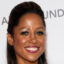

In [ ]:
SELECTED_ATTRIBUTES = ['Black_Hair', 'Blond_Hair', 'Brown_Hair']

small_config = get_experiment_configuration(repeat_num=1, num_iters=20000,
              batch_size=128, selected_attributes = SELECTED_ATTRIBUTES)

loader = get_loader(small_config, mode='test')
data_iter = iter(loader)
x_fixed, _ = next(data_iter)

from torchvision.transforms import ToPILImage
to_img = ToPILImage()

# display tensor
to_img( denorm( x_fixed[0]  ) )

### Modules for Generator and Discriminator

The following cell defines the generator and discriminator networks as `nn.Modules` .

In [ ]:
class ResidualBlock(nn.Module):
    """Residual Block with instance normalization."""
    def __init__(self, dim_in, dim_out):
        super(ResidualBlock, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(dim_in, dim_out, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(dim_out, affine=True, track_running_stats=True),
            nn.ReLU(inplace=True),
            nn.Conv2d(dim_out, dim_out, kernel_size=3, stride=1, padding=1, bias=False),
            nn.InstanceNorm2d(dim_out, affine=True, track_running_stats=True))

    def forward(self, x):
        return x + self.main(x)

class Generator(nn.Module):
    """Generator network."""
    def __init__(self, conv_dim=64, c_dim=5, repeat_num=6):
        super(Generator, self).__init__()

        layers = []
        layers.append(nn.Conv2d(3+c_dim, conv_dim, kernel_size=7, stride=1, padding=3, bias=False))
        layers.append(nn.InstanceNorm2d(conv_dim, affine=True, track_running_stats=True))
        layers.append(nn.ReLU(inplace=True))

        # Down-sampling layers.
        curr_dim = conv_dim
        for i in range(2):
            layers.append(nn.Conv2d(curr_dim, curr_dim*2, kernel_size=4, stride=2, padding=1, bias=False))
            layers.append(nn.InstanceNorm2d(curr_dim*2, affine=True, track_running_stats=True))
            layers.append(nn.ReLU(inplace=True))
            curr_dim = curr_dim * 2

        # Bottleneck layers.
        for i in range(repeat_num):
            layers.append(ResidualBlock(dim_in=curr_dim, dim_out=curr_dim))

        # Up-sampling layers.
        for i in range(2):
            layers.append(nn.ConvTranspose2d(curr_dim, curr_dim//2, kernel_size=4, stride=2, padding=1, bias=False))
            layers.append(nn.InstanceNorm2d(curr_dim//2, affine=True, track_running_stats=True))
            layers.append(nn.ReLU(inplace=True))
            curr_dim = curr_dim // 2

        layers.append(nn.Conv2d(curr_dim, 3, kernel_size=7, stride=1, padding=3, bias=False))
        layers.append(nn.Tanh())
        self.main = nn.Sequential(*layers)

    def forward(self, x, c):
        # Replicate spatially and concatenate domain information.
        # Note that this type of label conditioning does not work at all if we use reflection padding in Conv2d.
        # This is because instance normalization ignores the shifting (or bias) effect.
        c = c.view(c.size(0), c.size(1), 1, 1)
        c = c.repeat(1, 1, x.size(2), x.size(3))
        x = torch.cat([x, c], dim=1)
        return self.main(x)

class Discriminator(nn.Module):
    """Discriminator network."""
    def __init__(self, image_size=128, conv_dim=64, c_dim=5, repeat_num=6):
        super(Discriminator, self).__init__()
        layers = []
        layers.append(nn.Conv2d(3, conv_dim, kernel_size=4, stride=2, padding=1))
        layers.append(nn.LeakyReLU(0.01))

        curr_dim = conv_dim
        for i in range(1, repeat_num):
            layers.append(nn.Conv2d(curr_dim, curr_dim*2, kernel_size=4, stride=2, padding=1))
            layers.append(nn.LeakyReLU(0.01))
            curr_dim = curr_dim * 2

        kernel_size = int(image_size / np.power(2, repeat_num))
        self.main = nn.Sequential(*layers)
        self.conv1 = nn.Conv2d(curr_dim, 1, kernel_size=3, stride=1, padding=1, bias=False)
        self.conv2 = nn.Conv2d(curr_dim, c_dim, kernel_size=kernel_size, bias=False)
        
    def forward(self, x):
        h = self.main(x)
        out_src = self.conv1(h)
        out_cls = self.conv2(h)
        return out_src, out_cls.view(out_cls.size(0), out_cls.size(1))

Miscellaneous functions for updating learning rates, resetting the gradients and restoring a trained model from storage.

In [ ]:
def update_lr(g_optimizer, d_optimizer, g_lr, d_lr):
    """Decay learning rates of the generator and discriminator."""
    for param_group in g_optimizer.param_groups:
        param_group['lr'] = g_lr
    for param_group in d_optimizer.param_groups:
        param_group['lr'] = d_lr

def reset_grad(g_optimizer, d_optimizer):    
    g_optimizer.zero_grad()
    d_optimizer.zero_grad()

### Helper Functions

Implement the following helper functions to complete the training code. Follow the instructions in the questions below.



### Q3.1  Print number of parameters in the networks (5 points)

Write a function that takes input as a model and the model name, and prints the model and the number of parameters in the model.


In [ ]:
def print_network(model, name):
    print()
    print(f"{ name } network 1.0")
    print('=' * 100)
    num_params = 0

    model_parameters = [layer for layer in model.parameters() if layer.requires_grad]
    layer_names = [child for child in model.children()]
    
    for i, layer_name in enumerate(layer_names):
        if i > 0:
            print('-' * 100)
        print(layer_name)

    print('=' * 100)
    num_params = sum(map(lambda m: m.numel(), model_parameters))
    print("The number of parameters:" + " " * 40 + f"{num_params}")

### Q3.2 Invoke the optimizers on the Generator and Discriminator parameters (5 points)
Write a function that takes optimization parameters as input and returns optimizer functions for the discriminator and generator in PyTorch. Use [ADAM](https://arxiv.org/pdf/1412.6980.pdf) optimizer with the parameters $\beta_1$ and $\beta_2$ specified earlier.

In [ ]:
def get_optimizers(G: nn.Module,
                   D: nn.Module,
                   g_learning_rate: float,
                   d_learning_rate: float,
                   beta1,
                   beta2):
    """
    Returns a 2-tuple, optimizers for parameters of netD and netG
    """

    g_optimizer = optim.Adam(G.parameters(), lr=g_learning_rate, betas=(beta1, beta2))
    d_optimizer = optim.Adam(D.parameters(), lr=d_learning_rate, betas=(beta1, beta2))

    return g_optimizer, d_optimizer

### Q3.3 Compute classification loss (5 points)

Given the logits and the target labels, compute binary cross entropy loss $\ell_{\text{cls}}$ .

In [ ]:
import torch.nn.functional as F

def classification_loss(logit, target):
    """
    Compute binary cross entropy loss.
    """

    return F.binary_cross_entropy_with_logits(logit, target,
                                              size_average=False) / logit.size(0)

    # return F.binary_cross_entropy_with_logits(logit, target)

### Q3.4 Compute reconstruction loss (5 points)

This is a very popular loss function used in situations where you are given an original input $x$. In generative learning, through some latent space, you'll generate an almost replica of $x$, let us denote it by $\hat{x}$.

The reconstruction loss measures the distance between the replica and the original. Let $N$ be the number of elements in $x$ and $\hat{x}$, then the loss can be written as 

$$
\ell_{\text{rec}} =  \frac{1}{N} \sum^N_{i=1} | x_i - \hat{x}_i |
$$

In [ ]:
def reconstruction_loss( x_real, x_reconstructed ):
    """
    Compute the reconstruction loss.
    """

    x = x_real - x_reconstructed
    x = torch.abs(x)
    loss = torch.mean(x)
    
    return loss

### Q3.5 Implement the discriminator loss (5 points)
Write a function that returns the discriminator loss written as :

$$
\ell_{discriminator} = \ell_{real} + \ell_{fake}  +  \lambda_{cls} * \ell_{cls}
$$

Note that we add an additional term associated with the generated data (its simple to compute so we do it for you :P ).

In [ ]:
def get_discriminator_loss(G: nn.Module,
                           D: nn.Module,
                           label_org: torch.Tensor,
                           x_real: torch.Tensor,
                           c_trg: torch.Tensor,
                           lambda_cls: float,
                           lambda_gp: float):
    """
    x_real = x_real.to(device)           # Input images.
    c_trg = c_trg.to(device)             # Target labels.
    label_org = label_org.to(device)     # Labels for computing classification loss.
    label_trg = label_trg.to(device)     # Labels for computing classification loss.
    """

    out_src, out_cls = D(x_real)
    d_loss_real = -torch.mean(out_src)
    ################################################
    ##### CODE HERE
    ##### classification loss between out_cls, label_org
    d_loss_cls = classification_loss(out_cls, label_org)
    ################################################

    # Compute loss with fake images.
    x_fake = G(x_real, c_trg)
    out_src, out_cls = D(x_fake.detach())
    d_loss_fake = torch.mean(out_src)

    d_loss_gp = torch.tensor(0.0)

    # Backward and optimize.
    d_loss = d_loss_real + d_loss_fake
    ################################################
    ##### add remaining loss terms as described in the problem

    # add lambda_cls * d_loss_cls
    d_loss += lambda_cls * d_loss_cls
    ################################################
    
    # d_loss = d_loss_real + d_loss_fake + lambda_cls * d_loss_cls
    return d_loss, d_loss_real, d_loss_fake, d_loss_cls, d_loss_gp

### Q3.6 Implement the generator loss (5 points)

Write a function that returns the generator loss written as :

$$
\ell_{generator} = \ell_{fake} + \lambda_{rec} * \ell_{rec} +  \lambda_{cls} * \ell_{cls}
$$

Note that we add an additional term associated with the generated data (its simple to compute so we do it for you :P ).

In [ ]:
def get_generator_loss(G: nn.Module,
                       D: nn.Module,
                       x_real: torch.Tensor,
                       c_trg: torch.Tensor,
                       c_org: torch.Tensor,
                       label_trg: torch.Tensor,
                       lambda_rec: float,
                       lambda_cls: float):
    """
    """

    # Original-to-target domain.
    x_fake = G(x_real, c_trg)
    out_src, out_cls = D(x_fake)
    g_loss_fake = - torch.mean(out_src)

    ################################################
    ##### TODO CODE HERE
    ##### classification loss between out_cls and label_trg
    g_loss_cls = classification_loss(out_cls, label_trg)
    ################################################

    # Target-to-original domain.
    x_reconst = G(x_fake, c_org)
    ################################################
    ##### TODO CODE HERE
    ##### reconstruction loss between x_real and x_reconst
    g_loss_rec = reconstruction_loss(x_real, x_reconst)
    ################################################

    # Backward and optimize.
    g_loss = g_loss_fake
    ################################################
    ##### TODO CODE HERE
    ##### add remaining loss terms as described in the problem
    g_loss += lambda_rec * g_loss_rec
    g_loss += lambda_cls * g_loss_cls
    ################################################

    return g_loss, g_loss_fake, g_loss_cls, g_loss_rec

The following cell initializes the generator and discriminator. Prints both  neural networks, and allocates optimizers.

In [ ]:
# Instantiate Generator and Discriminator

SELECTED_ATTRIBUTES = ['Blond_Hair']

config = get_experiment_configuration(repeat_num=1, num_iters=10000, 
              log_step=100, sample_step=1000, model_save_step=1000, 
              batch_size=64, selected_attributes = SELECTED_ATTRIBUTES)

G = Generator(config['g_conv_dim'], config['c_dim'], config['g_repeat_num'])

D = Discriminator(config['image_size'], 
                  config['d_conv_dim'], 
                  config['c_dim'], 
                  config['d_repeat_num']) 

g_optimizer, d_optimizer = get_optimizers(G, D, 
                                          config['g_lr'], config['d_lr'], 
                                          config['beta1'], config['beta2'])

print_network(G, 'Generator')
print_network(D, 'Discriminator')
    
G = G.to(config['device'])
D = D.to(config['device'])



Please ensure you are using a GPU for computation
Will be using the following device for computation :  cuda

Generator network 1.0
Sequential(
  (0): Conv2d(4, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ResidualBlock(
    (main): Sequential(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU

In [ ]:
def create_labels(c_org, c_dim=5, selected_attrs=SELECTED_ATTRIBUTES):
    """Generate target domain labels for debugging and testing."""
    # Get hair color indices.
    hair_color_indices = []
    for i, attr_name in enumerate(selected_attrs):
        if attr_name in ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Gray_Hair']:
            hair_color_indices.append(i)

    c_trg_list = []
    for i in range(c_dim):
        c_trg = c_org.clone()
        if i in hair_color_indices:  # Set one hair color to 1 and the rest to 0.
            c_trg[:, i] = 1
            for j in hair_color_indices:
                if j != i:
                    c_trg[:, j] = 0
        else:
            c_trg[:, i] = (c_trg[:, i] == 0)  # Reverse attribute value.

        c_trg_list.append(c_trg.to(config['device']))
    return c_trg_list

# Set data loader.
data_loader = get_loader(config, 'train')
device = config['device']

# Fetch fixed inputs for debugging.
data_iter = iter(data_loader)
x_fixed, c_org = next(data_iter)
x_fixed = x_fixed.to(device)
c_fixed_list = create_labels(c_org, config['c_dim'], config['selected_attributes'])

Finished preprocessing the CelebA dataset...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


### Q3.7 : Training loop (10 points)
Now, using the functions defined above, implement the main training loop. Some of it has already been done for you. Fill in code where indicated.

Note that your after every `config['sample_step']`, the code generates new samples in the directory indicated in the configuration. Please monitor this to see how your generated images look like.


In [ ]:
# Learning rate cache for decaying.
g_lr = config['g_lr']
d_lr = config['d_lr']

# Start training from scratch or resume training.
start_iters = 0

G_losses = []
D_losses = []
cur_g_loss = 0
cur_d_loss = 0

# Start training.
print('Start training...')
start_time = time.time()
for i in range(start_iters, config['num_iters']):
    # =================================================================================== #
    #                             1. Preprocess input data                                #
    # =================================================================================== #

    # Fetch real images and labels.
    try:
        x_real, label_org = next(data_iter)
    except:
        data_iter = iter(data_loader)
        x_real, label_org = next(data_iter)

    # Generate target domain labels randomly.
    rand_idx = torch.randperm(label_org.size(0))
    label_trg = label_org[rand_idx]

    c_org = label_org.clone()
    c_trg = label_trg.clone()

    x_real = x_real.to(device)           # Input images.
    c_org = c_org.to(device)             # Original labels.
    c_trg = c_trg.to(device)             # Target labels.
    label_org = label_org.to(device)     # Labels for computing classification loss.
    label_trg = label_trg.to(device)     # Labels for computing classification loss.

    # Train discriminator
    ################################################
    ##### CODE HERE
    ##### Get the discriminator loss and optimize discriminator
    (d_loss, d_loss_real,
     d_loss_fake, d_loss_cls,
     d_loss_gp) = get_discriminator_loss(G, D, label_org,
        x_real, c_trg,
        config['lambda_cls'],
        config['lambda_gp'])
    
    # Now Optimize discriminator
    ################################################
    reset_grad(g_optimizer, d_optimizer)
    d_loss.backward()
    d_optimizer.step()

    cur_d_loss = d_loss.item()
    # Logging.
    loss = {}
    loss['D/loss_real'] = d_loss_real.item()
    loss['D/loss_fake'] = d_loss_fake.item()
    loss['D/loss_cls'] = d_loss_cls.item()
    loss['D/loss_gp'] = d_loss_gp.item()
    
    # Train the generator                         
    ################################################
    ##### CODE HERE
    ##### Get the generator loss and optimize generator
    (g_loss, g_loss_fake,
     g_loss_cls, g_loss_rec) = get_generator_loss(G, D,
        x_real, c_trg, c_org, label_trg,
        config['lambda_rec'],
        config['lambda_cls'])
    
    # Now Optimize generator
    ################################################
    g_loss.backward()
    g_optimizer.step()

    # Logging.
    loss['G/loss_fake'] = g_loss_fake.item()
    loss['G/loss_rec'] = g_loss_rec.item()
    loss['G/loss_cls'] = g_loss_cls.item()
    cur_g_loss = g_loss.item() 

    # Save Losses for plotting later
    G_losses.append(cur_g_loss)
    D_losses.append(cur_d_loss)

    # Print out training information.
    if (i+1) % config['log_step']  == 0:
        et = time.time() - start_time
        et = str(datetime.timedelta(seconds=et))[:-7]
        log = "Elapsed [{}], Iteration [{}/{}]".format(et, i+1, config['num_iters'])
        for tag, value in loss.items():
            log += ", {}: {:.4f}".format(tag, value)
        print(log)

    # Translate fixed images for debugging.
    if (i+1) %  config['sample_step']  == 0:
        with torch.no_grad():
            x_fake_list = [x_fixed]
            for c_fixed in c_fixed_list:
                x_fake_list.append(G(x_fixed, c_fixed))
            x_concat = torch.cat(x_fake_list, dim=3)
            sample_path = os.path.join(config['sample_dir'], '{}-images.jpg'.format(i+1))
            save_image(denorm(x_concat.data.cpu()), sample_path, nrow=1, padding=0)
            print('Saved real and fake images into {}...'.format(sample_path))

    # Decay learning rates.
    if (i+1) % config['lr_update_step'] == 0 and (i+1) > (config['num_iters'] - config['num_iters_decay']):
        g_lr -= (config['g_lr'] / float(config['num_iters_decay']))
        d_lr -= (config['d_lr'] / float(config['num_iters_decay']))
        update_lr(g_optimizer, d_optimizer, g_lr, d_lr)
        print ('Decayed learning rates, g_lr: {}, d_lr: {}.'.format(g_lr, d_lr))

Start training...
Elapsed [0:00:16], Iteration [100/10000], D/loss_real: -0.2861, D/loss_fake: 0.3338, D/loss_cls: 0.2775, D/loss_gp: 0.0000, G/loss_fake: 1.5733, G/loss_rec: 0.1871, G/loss_cls: 0.0329
Elapsed [0:00:32], Iteration [200/10000], D/loss_real: 0.0381, D/loss_fake: -0.0542, D/loss_cls: 0.1375, D/loss_gp: 0.0000, G/loss_fake: 1.5137, G/loss_rec: 0.1450, G/loss_cls: 0.0081
Elapsed [0:00:48], Iteration [300/10000], D/loss_real: 0.0700, D/loss_fake: -0.0985, D/loss_cls: 0.1607, D/loss_gp: 0.0000, G/loss_fake: 1.5655, G/loss_rec: 0.1461, G/loss_cls: 0.0083
Elapsed [0:01:04], Iteration [400/10000], D/loss_real: 0.0297, D/loss_fake: -0.0692, D/loss_cls: 0.2365, D/loss_gp: 0.0000, G/loss_fake: 1.4397, G/loss_rec: 0.1363, G/loss_cls: 0.0083
Elapsed [0:01:20], Iteration [500/10000], D/loss_real: 0.0343, D/loss_fake: -0.0637, D/loss_cls: 0.1987, D/loss_gp: 0.0000, G/loss_fake: 1.3368, G/loss_rec: 0.1267, G/loss_cls: 0.0044
Elapsed [0:01:36], Iteration [600/10000], D/loss_real: 0.0332,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [0:08:34], Iteration [3200/10000], D/loss_real: -0.1520, D/loss_fake: 0.1183, D/loss_cls: 0.2404, D/loss_gp: 0.0000, G/loss_fake: 0.7111, G/loss_rec: 0.0825, G/loss_cls: 0.0017
Elapsed [0:08:50], Iteration [3300/10000], D/loss_real: -0.1356, D/loss_fake: 0.1088, D/loss_cls: 0.1255, D/loss_gp: 0.0000, G/loss_fake: 0.6630, G/loss_rec: 0.0772, G/loss_cls: 0.0023
Elapsed [0:09:07], Iteration [3400/10000], D/loss_real: -0.1503, D/loss_fake: 0.1289, D/loss_cls: 0.1874, D/loss_gp: 0.0000, G/loss_fake: 0.7852, G/loss_rec: 0.0904, G/loss_cls: 0.0018
Elapsed [0:09:23], Iteration [3500/10000], D/loss_real: -0.1320, D/loss_fake: 0.1185, D/loss_cls: 0.1228, D/loss_gp: 0.0000, G/loss_fake: 0.6403, G/loss_rec: 0.0748, G/loss_cls: 0.0023
Elapsed [0:09:39], Iteration [3600/10000], D/loss_real: -0.1622, D/loss_fake: 0.1517, D/loss_cls: 0.1698, D/loss_gp: 0.0000, G/loss_fake: 0.6977, G/loss_rec: 0.0842, G/loss_cls: 0.0045
Elapsed [0:09:55], Iteration [3700/10000], D/loss_real: -0.1651, D/loss_fak

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [0:17:09], Iteration [6400/10000], D/loss_real: -0.3971, D/loss_fake: 0.3826, D/loss_cls: 0.1966, D/loss_gp: 0.0000, G/loss_fake: 0.3179, G/loss_rec: 0.0703, G/loss_cls: 0.0033
Elapsed [0:17:26], Iteration [6500/10000], D/loss_real: -0.4060, D/loss_fake: 0.3932, D/loss_cls: 0.1532, D/loss_gp: 0.0000, G/loss_fake: 0.2702, G/loss_rec: 0.0660, G/loss_cls: 0.0031
Elapsed [0:17:42], Iteration [6600/10000], D/loss_real: -0.4145, D/loss_fake: 0.3907, D/loss_cls: 0.1881, D/loss_gp: 0.0000, G/loss_fake: 0.2542, G/loss_rec: 0.0640, G/loss_cls: 0.0045
Elapsed [0:17:58], Iteration [6700/10000], D/loss_real: -0.4172, D/loss_fake: 0.3950, D/loss_cls: 0.2587, D/loss_gp: 0.0000, G/loss_fake: 0.3141, G/loss_rec: 0.0699, G/loss_cls: 0.0022
Elapsed [0:18:14], Iteration [6800/10000], D/loss_real: -0.4425, D/loss_fake: 0.4245, D/loss_cls: 0.1670, D/loss_gp: 0.0000, G/loss_fake: 0.2619, G/loss_rec: 0.0691, G/loss_cls: 0.0021
Elapsed [0:18:30], Iteration [6900/10000], D/loss_real: -0.4227, D/loss_fak

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [0:25:28], Iteration [9500/10000], D/loss_real: -0.7631, D/loss_fake: 0.7614, D/loss_cls: 0.0872, D/loss_gp: 0.0000, G/loss_fake: -0.1915, G/loss_rec: 0.0571, G/loss_cls: 0.0023
Elapsed [0:25:44], Iteration [9600/10000], D/loss_real: -0.7853, D/loss_fake: 0.7832, D/loss_cls: 0.0980, D/loss_gp: 0.0000, G/loss_fake: -0.1774, G/loss_rec: 0.0607, G/loss_cls: 0.0021
Elapsed [0:26:01], Iteration [9700/10000], D/loss_real: -0.8211, D/loss_fake: 0.8103, D/loss_cls: 0.0930, D/loss_gp: 0.0000, G/loss_fake: -0.2125, G/loss_rec: 0.0604, G/loss_cls: 0.0018
Elapsed [0:26:17], Iteration [9800/10000], D/loss_real: -0.7789, D/loss_fake: 0.7819, D/loss_cls: 0.1483, D/loss_gp: 0.0000, G/loss_fake: -0.2208, G/loss_rec: 0.0565, G/loss_cls: 0.0011
Elapsed [0:26:33], Iteration [9900/10000], D/loss_real: -0.8141, D/loss_fake: 0.7974, D/loss_cls: 0.1741, D/loss_gp: 0.0000, G/loss_fake: -0.2280, G/loss_rec: 0.0565, G/loss_cls: 0.0070
Elapsed [0:26:49], Iteration [10000/10000], D/loss_real: -0.8220, D/lo

- Plot the generator and discriminator losses. Remember to leave this output intact when you submit the notebook. Not doing so would result in a 2 points penalty.

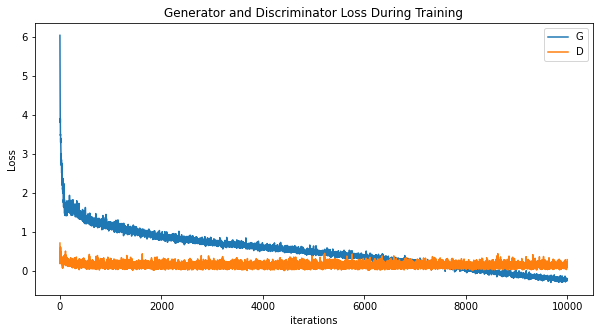

In [ ]:
# Losses
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

## Q4: Hair-style transformation [60 points]

In this problem, we will take image and change hair styles as per the trained GAN in the previous step

### Q4.1 : Save trained model (5 points)

We will implement a routine to save the trained generator and discrimantor models, so that we can simply load these later on for inference.

In [ ]:
def save_model(G: nn.Module,
               D: nn.Module,
               config,
               step):
    """
    Save the trained generator and discriminator
    """
    model_save_dir = config['model_save_dir']
    G_path = os.path.join(model_save_dir, '{}-G.ckpt'.format(step+1))
    D_path = os.path.join(model_save_dir, '{}-D.ckpt'.format(step+1))

    ################################################
    ##### CODE HERE
    torch.save(G.state_dict(), G_path)
    torch.save(D.state_dict(), D_path)
    ################################################
    
    print('Saved model checkpoints into {}...'.format(model_save_dir))


### Q4.2 : Load trained model (5 points)

We will implement a routine to load the trained generator and discrimantor models.

In [ ]:
def restore_model(resume_iters, model_save_dir):
    """
    Restore the trained generator and discriminator.
    """

    print('Loading the trained models from step {}...'.format(resume_iters))
    G_path = os.path.join(model_save_dir, '{}-G.ckpt'.format(resume_iters))
    D_path = os.path.join(model_save_dir, '{}-D.ckpt'.format(resume_iters))

    ################################################
    ##### CODE HERE
    G.load_state_dict(torch.load(G_path, map_location=lambda storage, loc: storage))
    D.load_state_dict(torch.load(D_path, map_location=lambda storage, loc: storage))
    ################################################

    return G, D

### Q4.3 Implement gradient penalty (10 points)

Given $y = f(x)$, we refer $ \frac{ dy }{ dx } $ as the gradient in this problem. We want to include a gradient penalty in the GAN loss. 
We can write gradient penalty $\ell_{gp}$ as 

$$
\ell_{gp} = \Bigg\|  \Big\| \frac{ dy }{ dx } \Big\|_2 - 1 \Bigg\|^2
$$

(Hint : Using ```grad``` function in the ```torch.autograd``` modules, compute the gradient penalty )

In [ ]:
def gradient_penalty(y, x):
    """
    Compute gradient penalty: (L2_norm(dy/dx) - 1)**2.
    """

    ################################################
    #####
    weight = torch.ones(y.size()).to(config['device'])
    dydx = torch.autograd.grad(outputs=y,
                               inputs=x,
                               grad_outputs=weight,
                               retain_graph=True,
                               create_graph=True,
                               only_inputs=True)[0]

    dydx = dydx.view(dydx.size(0), -1)
    dydx_l2norm = torch.sqrt(torch.sum(dydx**2, dim=1))
    ################################################

    loss = torch.mean((dydx_l2norm-1)**2)
    return loss

### Q4.4 Implement the discriminator loss (5 points)
Write a function that returns the discriminator loss written as :

$$
\ell_{discriminator} = \ell_{real} + \ell_{fake} + \lambda_{gp} \times \ell_{gp} +  \lambda_{cls} \times \ell_{cls}
$$

Note that we add an additional term associated with the generated data (its simple to compute so we do it for you :P ).

In [ ]:

def get_new_discriminator_loss(
    G: nn.Module,
    D: nn.Module,
    label_org: torch.Tensor,
    x_real: torch.Tensor,
    c_trg: torch.Tensor,
    lambda_cls: float,
    lambda_gp: float):
    """
    x_real = x_real.to(device)           # Input images.
    c_trg = c_trg.to(device)             # Target labels.
    label_org = label_org.to(device)     # Labels for computing classification loss.
    label_trg = label_trg.to(device)     # Labels for computing classification loss.
    """

    out_src, out_cls = D(x_real)
    d_loss_real = -torch.mean(out_src)
    ################################################
    ##### CODE HERE
    ##### classification loss between out_cls, label_org
    d_loss_cls = classification_loss(out_cls, label_org)
    ################################################

    # Compute loss with fake images.
    x_fake = G(x_real, c_trg)
    out_src, out_cls = D(x_fake.detach())
    d_loss_fake = torch.mean(out_src)

    # Compute loss for gradient penalty.
    alpha = torch.rand(x_real.size(0), 1, 1, 1).to(device)
    x_hat = (alpha * x_real.data + (1 - alpha) * x_fake.data).requires_grad_(True)
    out_src, _ = D(x_hat)
    ################################################
    ##### TODO CODE HERE
    ##### gradient penalty on y=out_src, x=x_hat
    d_loss_gp = gradient_penalty(out_src, x_hat)
    ################################################

    # Backward and optimize.
    d_loss = d_loss_real + d_loss_fake
    ################################################
    ##### CODE HERE
    ##### add remaining loss terms as described in the problem
    d_loss += lambda_cls * d_loss_cls
    d_loss += lambda_gp * d_loss_gp
    ################################################
    
    return d_loss, d_loss_real, d_loss_fake, d_loss_cls, d_loss_gp

### Q4.5 : Initialize a larger GAN using ```get_experiment_configuration``` (10 points)

We will use three hair style attributes in this experiment.

We will train a larger GAN in this problem. First, lets get a larger generator and discriminator models (use more than 3 repeat blocks in the experiment configuration which will increase the number of residual blocks in both the models).

Initialize the generator and discriminator accordingly and get the optimizers.

In [ ]:

SELECTED_ATTRIBUTES = ['Black_Hair', 'Blond_Hair', 'Brown_Hair']

################################################
config = get_experiment_configuration(
    log_step=100,
    sample_step=1000,
    model_save_step=1000,
    batch_size=64,
    selected_attributes = SELECTED_ATTRIBUTES)

G = Generator(config['g_conv_dim'], config['c_dim'], config['g_repeat_num'])

D = Discriminator(config['image_size'], 
                  config['d_conv_dim'], 
                  config['c_dim'], 
                  config['d_repeat_num']) 

g_optimizer, d_optimizer = get_optimizers(G, D, 
                                          config['g_lr'], config['d_lr'], 
                                          config['beta1'], config['beta2'])

data_loader = get_loader(config, mode='train')

# Fetch fixed inputs for debugging.
data_iter = iter(data_loader)
x_fixed, c_org = next(data_iter)
x_fixed = x_fixed.to(device)
c_fixed_list = create_labels(c_org, config['c_dim'], config['selected_attributes'])

################################################

print_network(G, 'Generator')
print_network(D, 'Discriminator')
    
G = G.to(config['device'])
D = D.to(config['device'])





Please ensure you are using a GPU for computation
Will be using the following device for computation :  cuda
Finished preprocessing the CelebA dataset...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index



Generator network 1.0
Sequential(
  (0): Conv2d(6, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (5): ReLU(inplace=True)
  (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  (7): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): ReLU(inplace=True)
  (9): ResidualBlock(
    (main): Sequential(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     

### Q4.6 : Train the larger GAN (15 points)

At the heart of a GAN network is a minimax problem. Earlier we were optimizing the Generator and the Discriminator at the same speed. 

It turns out that in this case, its recommended that the generator is updated at a slower pace than the discriminator. 

One way to achieve this is to run the generator with smaller learning rate . Instead we want to use the same learning rates as before but we will update the generator every few iterations, i.e. discriminator will be trained in every iteration but the generator will be trained every 5 iterations or more specifically ```config['n_critic']``` number of iterations. Use this recommended value or update as per your intuition.

Note that your after every `config['sample_step']`, the code generates new samples in the directory indicated in the configuration. Please monitor this to see how your generated images look like.

The script also saves your model to the `config['model_save_dir']` every `config['mode_save_step']` so that you can resume training (in case your script crashes after making significant progress) and we can also restore this model when we generate new hairstyles on the test images.

Hopefully your results will be better with these updates.

This will take more than 10 hours to give you reasonable images. So start early.


In [ ]:
# Learning rate cache for decaying.
g_lr = config['g_lr']
d_lr = config['d_lr']

# Start training from scratch or resume training.
start_iters = 0
if config['resume_iters']:
    start_iters = config['resume_iters'] 
    G, D = restore_model(config['resume_iters'], config )

G_losses = []
D_losses = []
cur_g_loss = 0
cur_d_loss = 0

# Start training.
print('Start training...')
start_time = time.time()
for i in range(start_iters, config['num_iters']):
    # =================================================================================== #
    #                             1. Preprocess input data                                #
    # =================================================================================== #

    # Fetch real images and labels.
    try:
        x_real, label_org = next(data_iter)
    except:
        data_iter = iter(data_loader)
        x_real, label_org = next(data_iter)

    # Generate target domain labels randomly.
    rand_idx = torch.randperm(label_org.size(0))
    label_trg = label_org[rand_idx]

    c_org = label_org.clone()
    c_trg = label_trg.clone()

    x_real = x_real.to(device)           # Input images.
    c_org = c_org.to(device)             # Original labels.
    c_trg = c_trg.to(device)             # Target labels.
    label_org = label_org.to(device)     # Labels for computing classification loss.
    label_trg = label_trg.to(device)     # Labels for computing classification loss.

    # Train discriminator
    ################################################
    ##### CODE HERE
    ##### Get the discriminator loss and optimize discriminator
    (d_loss, d_loss_real,
     d_loss_fake, d_loss_cls,
     d_loss_gp) = get_new_discriminator_loss(G, D, label_org,
        x_real, c_trg,
        config['lambda_cls'],
        config['lambda_gp'])
    
    # Now Optimize discriminator
    ################################################
    reset_grad(g_optimizer, d_optimizer)
    d_loss.backward()
    d_optimizer.step()

    cur_d_loss = d_loss.item()
    # Logging.
    loss = {}
    loss['D/loss_real'] = d_loss_real.item()
    loss['D/loss_fake'] = d_loss_fake.item()
    loss['D/loss_cls'] = d_loss_cls.item()
    loss['D/loss_gp'] = d_loss_gp.item()
    
    # Train the generator                         
    ################################################
    ##### TODO CODE HERE
    ##### Get the generator loss and optimize generator (every n_critic iterations)
    (g_loss, g_loss_fake,
     g_loss_cls, g_loss_rec) = get_generator_loss(G, D,
        x_real, c_trg, c_org, label_trg,
        config['lambda_rec'],
        config['lambda_cls'])
    
    # Now Optimize generator
    g_loss.backward()
    g_optimizer.step()

    # Logging.
    loss['G/loss_fake'] = g_loss_fake.item()
    loss['G/loss_rec'] = g_loss_rec.item()
    loss['G/loss_cls'] = g_loss_cls.item()
    ################################################
        
    # Print out training information.
    if (i+1) % config['log_step']  == 0:
        et = time.time() - start_time
        et = str(datetime.timedelta(seconds=et))[:-7]
        log = "Elapsed [{}], Iteration [{}/{}]".format(et, i+1, config['num_iters'])
        for tag, value in loss.items():
            log += ", {}: {:.4f}".format(tag, value)
        print(log)

    # Translate fixed images for debugging.
    if (i+1) %  config['sample_step']  == 0:
        with torch.no_grad():
            x_fake_list = [x_fixed]
            for c_fixed in c_fixed_list:
                x_fake_list.append(G(x_fixed, c_fixed))
            x_concat = torch.cat(x_fake_list, dim=3)
            sample_path = os.path.join(config['sample_dir'], '{}-images.jpg'.format(i+1))
            save_image(denorm(x_concat.data.cpu()), sample_path, nrow=1, padding=0)
            print('Saved real and fake images into {}...'.format(sample_path))

    # Save model checkpoints.
    if (i+1) % config['model_save_step'] == 0:
        save_model(G, D, config, i)

    # Decay learning rates.
    if (i+1) % config['lr_update_step'] == 0 and (i+1) > (config['num_iters'] - config['num_iters_decay']):
        g_lr -= (config['g_lr'] / float(config['num_iters_decay']))
        d_lr -= (config['d_lr'] / float(config['num_iters_decay']))
        update_lr(g_optimizer, d_optimizer, g_lr, d_lr)
        print ('Decayed learning rates, g_lr: {}, d_lr: {}.'.format(g_lr, d_lr))

Start training...


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Elapsed [0:00:29], Iteration [100/200000], D/loss_real: -1.9901, D/loss_fake: 3.5162, D/loss_cls: 1.3864, D/loss_gp: 0.8088, G/loss_fake: 0.7713, G/loss_rec: 0.2724, G/loss_cls: 1.4210
Elapsed [0:00:58], Iteration [200/200000], D/loss_real: -0.0537, D/loss_fake: 0.2945, D/loss_cls: 1.9643, D/loss_gp: 0.7918, G/loss_fake: 3.7054, G/loss_rec: 0.2136, G/loss_cls: 1.9220
Elapsed [0:01:26], Iteration [300/200000], D/loss_real: 1.0828, D/loss_fake: -0.9845, D/loss_cls: 1.4153, D/loss_gp: 0.0107, G/loss_fake: 4.6033, G/loss_rec: 0.1940, G/loss_cls: 1.3641
Elapsed [0:01:55], Iteration [400/200000], D/loss_real: -0.5543, D/loss_fake: 0.9045, D/loss_cls: 1.6000, D/loss_gp: 0.6042, G/loss_fake: 2.7950, G/loss_rec: 0.2341, G/loss_cls: 1.5046
Elapsed [0:02:23], Iteration [500/200000], D/loss_real: -0.5624, D/loss_fake: 2.1796, D/loss_cls: 1.5813, D/loss_gp: 0.0993, G/loss_fake: 2.8362, G/loss_rec: 0.2200, G/loss_cls: 1.5903
Elapsed [0:02:51], Iteration [600/200000], D/loss_real: 0.4789, D/loss_fake

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [0:15:07], Iteration [3200/200000], D/loss_real: -1.9979, D/loss_fake: 1.9943, D/loss_cls: 1.4751, D/loss_gp: 0.0068, G/loss_fake: 0.3447, G/loss_rec: 0.1070, G/loss_cls: 1.4289
Elapsed [0:15:36], Iteration [3300/200000], D/loss_real: -2.0312, D/loss_fake: 2.2280, D/loss_cls: 1.3783, D/loss_gp: 0.0051, G/loss_fake: 0.0668, G/loss_rec: 0.1148, G/loss_cls: 1.2178
Elapsed [0:16:04], Iteration [3400/200000], D/loss_real: -1.8072, D/loss_fake: 1.9534, D/loss_cls: 1.3652, D/loss_gp: 0.0078, G/loss_fake: -0.0591, G/loss_rec: 0.1096, G/loss_cls: 1.1246
Elapsed [0:16:33], Iteration [3500/200000], D/loss_real: -2.3455, D/loss_fake: 2.3598, D/loss_cls: 1.1434, D/loss_gp: 0.0027, G/loss_fake: -0.5247, G/loss_rec: 0.1081, G/loss_cls: 1.0110
Elapsed [0:17:01], Iteration [3600/200000], D/loss_real: -2.5875, D/loss_fake: 2.7065, D/loss_cls: 1.1557, D/loss_gp: 0.0043, G/loss_fake: -0.4296, G/loss_rec: 0.1027, G/loss_cls: 0.9242
Elapsed [0:17:29], Iteration [3700/200000], D/loss_real: -2.4349, D

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [0:30:17], Iteration [6400/200000], D/loss_real: -2.9930, D/loss_fake: 2.9589, D/loss_cls: 0.8204, D/loss_gp: 0.0027, G/loss_fake: -1.5189, G/loss_rec: 0.0894, G/loss_cls: 0.5151
Elapsed [0:30:45], Iteration [6500/200000], D/loss_real: -3.3160, D/loss_fake: 3.1628, D/loss_cls: 0.9850, D/loss_gp: 0.0035, G/loss_fake: -1.5354, G/loss_rec: 0.0881, G/loss_cls: 0.5090
Elapsed [0:31:13], Iteration [6600/200000], D/loss_real: -3.1961, D/loss_fake: 3.1373, D/loss_cls: 0.9293, D/loss_gp: 0.0040, G/loss_fake: -1.1888, G/loss_rec: 0.1029, G/loss_cls: 0.4533
Elapsed [0:31:41], Iteration [6700/200000], D/loss_real: -3.2031, D/loss_fake: 3.1245, D/loss_cls: 0.7335, D/loss_gp: 0.0036, G/loss_fake: -1.6390, G/loss_rec: 0.0889, G/loss_cls: 0.3971
Elapsed [0:32:10], Iteration [6800/200000], D/loss_real: -3.2663, D/loss_fake: 3.1482, D/loss_cls: 1.1565, D/loss_gp: 0.0028, G/loss_fake: -1.6294, G/loss_rec: 0.0868, G/loss_cls: 0.4231
Elapsed [0:32:38], Iteration [6900/200000], D/loss_real: -2.5302,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [0:44:53], Iteration [9500/200000], D/loss_real: -1.8264, D/loss_fake: 1.8822, D/loss_cls: 0.8291, D/loss_gp: 0.0034, G/loss_fake: -0.6061, G/loss_rec: 0.0815, G/loss_cls: 0.3280
Elapsed [0:45:21], Iteration [9600/200000], D/loss_real: -1.7000, D/loss_fake: 1.5645, D/loss_cls: 0.9671, D/loss_gp: 0.0040, G/loss_fake: -0.2962, G/loss_rec: 0.0889, G/loss_cls: 0.3359
Elapsed [0:45:49], Iteration [9700/200000], D/loss_real: -2.1419, D/loss_fake: 2.3434, D/loss_cls: 0.6073, D/loss_gp: 0.0058, G/loss_fake: -0.7731, G/loss_rec: 0.0895, G/loss_cls: 0.2795
Elapsed [0:46:17], Iteration [9800/200000], D/loss_real: -1.8023, D/loss_fake: 1.7021, D/loss_cls: 0.8324, D/loss_gp: 0.0055, G/loss_fake: -0.5035, G/loss_rec: 0.0763, G/loss_cls: 0.3464
Elapsed [0:46:45], Iteration [9900/200000], D/loss_real: -1.9362, D/loss_fake: 1.7411, D/loss_cls: 0.6625, D/loss_gp: 0.0042, G/loss_fake: -0.3265, G/loss_rec: 0.0868, G/loss_cls: 0.4137
Elapsed [0:47:13], Iteration [10000/200000], D/loss_real: -1.8736

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [0:59:57], Iteration [12700/200000], D/loss_real: -1.0683, D/loss_fake: 0.6795, D/loss_cls: 0.7263, D/loss_gp: 0.0073, G/loss_fake: 0.5584, G/loss_rec: 0.0832, G/loss_cls: 0.3236
Elapsed [1:00:25], Iteration [12800/200000], D/loss_real: -0.6579, D/loss_fake: 0.4831, D/loss_cls: 0.8042, D/loss_gp: 0.0098, G/loss_fake: 0.6363, G/loss_rec: 0.0736, G/loss_cls: 0.3012
Elapsed [1:00:53], Iteration [12900/200000], D/loss_real: -1.0787, D/loss_fake: 0.8850, D/loss_cls: 0.7521, D/loss_gp: 0.0071, G/loss_fake: 0.5033, G/loss_rec: 0.0803, G/loss_cls: 0.3200
Elapsed [1:01:21], Iteration [13000/200000], D/loss_real: -1.2883, D/loss_fake: 1.2076, D/loss_cls: 0.6420, D/loss_gp: 0.0038, G/loss_fake: -0.0453, G/loss_rec: 0.0734, G/loss_cls: 0.2885
Saved real and fake images into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/sample_dir-6-cdim-3/13000-images.jpg...
Saved model checkpoints into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experime

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [1:15:01], Iteration [15900/200000], D/loss_real: -1.1613, D/loss_fake: 0.7548, D/loss_cls: 0.7104, D/loss_gp: 0.0039, G/loss_fake: 0.5870, G/loss_rec: 0.0801, G/loss_cls: 0.3141
Elapsed [1:15:29], Iteration [16000/200000], D/loss_real: -0.7399, D/loss_fake: 1.3603, D/loss_cls: 0.5826, D/loss_gp: 0.0049, G/loss_fake: 0.4939, G/loss_rec: 0.0798, G/loss_cls: 0.3279
Saved real and fake images into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/sample_dir-6-cdim-3/16000-images.jpg...
Saved model checkpoints into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/model_save_dir-6-cdim-3...
Elapsed [1:15:58], Iteration [16100/200000], D/loss_real: -0.9270, D/loss_fake: 0.7808, D/loss_cls: 0.7080, D/loss_gp: 0.0039, G/loss_fake: 0.3861, G/loss_rec: 0.0733, G/loss_cls: 0.3735
Elapsed [1:16:27], Iteration [16200/200000], D/loss_real: -0.9293, D/loss_fake: 0.8302, D/loss_cls: 0.6040, D/loss_gp: 0.0040, G/loss_fake: 0.3833, G/loss_re

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [1:29:38], Iteration [19000/200000], D/loss_real: -0.7146, D/loss_fake: 0.8423, D/loss_cls: 0.7369, D/loss_gp: 0.0038, G/loss_fake: 0.4014, G/loss_rec: 0.0740, G/loss_cls: 0.3077
Saved real and fake images into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/sample_dir-6-cdim-3/19000-images.jpg...
Saved model checkpoints into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/model_save_dir-6-cdim-3...
Elapsed [1:30:07], Iteration [19100/200000], D/loss_real: -0.5069, D/loss_fake: 0.4267, D/loss_cls: 0.6840, D/loss_gp: 0.0030, G/loss_fake: 0.6727, G/loss_rec: 0.0698, G/loss_cls: 0.3307
Elapsed [1:30:35], Iteration [19200/200000], D/loss_real: -0.2338, D/loss_fake: 0.1976, D/loss_cls: 0.5741, D/loss_gp: 0.0077, G/loss_fake: 1.1879, G/loss_rec: 0.0821, G/loss_cls: 0.3264
Elapsed [1:31:03], Iteration [19300/200000], D/loss_real: -0.4066, D/loss_fake: 0.4240, D/loss_cls: 0.6031, D/loss_gp: 0.0061, G/loss_fake: 0.9079, G/loss_re

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [1:44:43], Iteration [22200/200000], D/loss_real: -0.0544, D/loss_fake: 0.1752, D/loss_cls: 0.5284, D/loss_gp: 0.0064, G/loss_fake: 1.0207, G/loss_rec: 0.0727, G/loss_cls: 0.3910
Elapsed [1:45:11], Iteration [22300/200000], D/loss_real: -0.3088, D/loss_fake: 0.2757, D/loss_cls: 0.7812, D/loss_gp: 0.0043, G/loss_fake: 1.0457, G/loss_rec: 0.0742, G/loss_cls: 0.3666
Elapsed [1:45:39], Iteration [22400/200000], D/loss_real: -0.6796, D/loss_fake: 0.5888, D/loss_cls: 0.6743, D/loss_gp: 0.0033, G/loss_fake: 0.7305, G/loss_rec: 0.0716, G/loss_cls: 0.4299
Elapsed [1:46:07], Iteration [22500/200000], D/loss_real: -0.4648, D/loss_fake: 0.5177, D/loss_cls: 0.5597, D/loss_gp: 0.0046, G/loss_fake: 0.6576, G/loss_rec: 0.0681, G/loss_cls: 0.3050
Elapsed [1:46:35], Iteration [22600/200000], D/loss_real: -0.3071, D/loss_fake: 0.4129, D/loss_cls: 0.7092, D/loss_gp: 0.0026, G/loss_fake: 0.7869, G/loss_rec: 0.0660, G/loss_cls: 0.3813
Elapsed [1:47:04], Iteration [22700/200000], D/loss_real: -0.3886

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [1:59:47], Iteration [25400/200000], D/loss_real: -0.4265, D/loss_fake: 0.2073, D/loss_cls: 0.7518, D/loss_gp: 0.0049, G/loss_fake: 1.0462, G/loss_rec: 0.0700, G/loss_cls: 0.2785
Elapsed [2:00:15], Iteration [25500/200000], D/loss_real: -0.6777, D/loss_fake: 0.5039, D/loss_cls: 0.7463, D/loss_gp: 0.0050, G/loss_fake: 0.6963, G/loss_rec: 0.0630, G/loss_cls: 0.4181
Elapsed [2:00:43], Iteration [25600/200000], D/loss_real: -0.5513, D/loss_fake: 0.2749, D/loss_cls: 0.6344, D/loss_gp: 0.0040, G/loss_fake: 0.7982, G/loss_rec: 0.0697, G/loss_cls: 0.3228
Elapsed [2:01:12], Iteration [25700/200000], D/loss_real: -0.3113, D/loss_fake: 0.5252, D/loss_cls: 0.5595, D/loss_gp: 0.0092, G/loss_fake: 0.9186, G/loss_rec: 0.0689, G/loss_cls: 0.2130
Elapsed [2:01:40], Iteration [25800/200000], D/loss_real: -0.4902, D/loss_fake: 0.3484, D/loss_cls: 0.7745, D/loss_gp: 0.0046, G/loss_fake: 0.8706, G/loss_rec: 0.0644, G/loss_cls: 0.3882
Elapsed [2:02:08], Iteration [25900/200000], D/loss_real: -0.4610

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [2:14:23], Iteration [28500/200000], D/loss_real: 0.0430, D/loss_fake: -0.1821, D/loss_cls: 0.4870, D/loss_gp: 0.0045, G/loss_fake: 1.1991, G/loss_rec: 0.0660, G/loss_cls: 0.2331
Elapsed [2:14:51], Iteration [28600/200000], D/loss_real: -0.3129, D/loss_fake: 0.1025, D/loss_cls: 0.7667, D/loss_gp: 0.0060, G/loss_fake: 0.9082, G/loss_rec: 0.0622, G/loss_cls: 0.2644
Elapsed [2:15:19], Iteration [28700/200000], D/loss_real: -0.5851, D/loss_fake: 0.2502, D/loss_cls: 0.6418, D/loss_gp: 0.0083, G/loss_fake: 0.7143, G/loss_rec: 0.0626, G/loss_cls: 0.2179
Elapsed [2:15:48], Iteration [28800/200000], D/loss_real: 0.1219, D/loss_fake: -0.3489, D/loss_cls: 0.6134, D/loss_gp: 0.0051, G/loss_fake: 1.4511, G/loss_rec: 0.0653, G/loss_cls: 0.2995
Elapsed [2:16:16], Iteration [28900/200000], D/loss_real: -0.1780, D/loss_fake: -0.0235, D/loss_cls: 0.7200, D/loss_gp: 0.0069, G/loss_fake: 1.1955, G/loss_rec: 0.0663, G/loss_cls: 0.3961
Elapsed [2:16:44], Iteration [29000/200000], D/loss_real: -0.152

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [2:29:28], Iteration [31700/200000], D/loss_real: -0.5742, D/loss_fake: 0.4190, D/loss_cls: 0.6203, D/loss_gp: 0.0052, G/loss_fake: 0.7452, G/loss_rec: 0.0606, G/loss_cls: 0.3185
Elapsed [2:29:56], Iteration [31800/200000], D/loss_real: -0.4438, D/loss_fake: 0.5484, D/loss_cls: 0.6059, D/loss_gp: 0.0039, G/loss_fake: 0.6573, G/loss_rec: 0.0637, G/loss_cls: 0.3388
Elapsed [2:30:24], Iteration [31900/200000], D/loss_real: -0.4659, D/loss_fake: 0.1356, D/loss_cls: 0.7625, D/loss_gp: 0.0036, G/loss_fake: 0.9264, G/loss_rec: 0.0673, G/loss_cls: 0.3092
Elapsed [2:30:52], Iteration [32000/200000], D/loss_real: -0.2213, D/loss_fake: -0.0450, D/loss_cls: 0.6029, D/loss_gp: 0.0050, G/loss_fake: 1.1179, G/loss_rec: 0.0602, G/loss_cls: 0.2704
Saved real and fake images into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/sample_dir-6-cdim-3/32000-images.jpg...
Saved model checkpoints into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experime

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [2:44:34], Iteration [34900/200000], D/loss_real: -0.3563, D/loss_fake: 0.2596, D/loss_cls: 0.5126, D/loss_gp: 0.0050, G/loss_fake: 0.7724, G/loss_rec: 0.0651, G/loss_cls: 0.2048
Elapsed [2:45:02], Iteration [35000/200000], D/loss_real: -0.5452, D/loss_fake: 0.4565, D/loss_cls: 0.6511, D/loss_gp: 0.0047, G/loss_fake: 0.6532, G/loss_rec: 0.0611, G/loss_cls: 0.2425
Saved real and fake images into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/sample_dir-6-cdim-3/35000-images.jpg...
Saved model checkpoints into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/model_save_dir-6-cdim-3...
Elapsed [2:45:31], Iteration [35100/200000], D/loss_real: -0.3132, D/loss_fake: 0.1441, D/loss_cls: 0.6253, D/loss_gp: 0.0038, G/loss_fake: 0.9163, G/loss_rec: 0.0607, G/loss_cls: 0.2416
Elapsed [2:45:59], Iteration [35200/200000], D/loss_real: -0.3461, D/loss_fake: 0.0265, D/loss_cls: 0.5658, D/loss_gp: 0.0054, G/loss_fake: 0.8533, G/loss_re

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [2:59:11], Iteration [38000/200000], D/loss_real: -0.4438, D/loss_fake: 0.3203, D/loss_cls: 0.4429, D/loss_gp: 0.0038, G/loss_fake: 0.6176, G/loss_rec: 0.0606, G/loss_cls: 0.2944
Saved real and fake images into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/sample_dir-6-cdim-3/38000-images.jpg...
Saved model checkpoints into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/model_save_dir-6-cdim-3...
Elapsed [2:59:40], Iteration [38100/200000], D/loss_real: -0.4402, D/loss_fake: 0.3310, D/loss_cls: 0.7490, D/loss_gp: 0.0045, G/loss_fake: 0.7661, G/loss_rec: 0.0565, G/loss_cls: 0.3626
Elapsed [3:00:08], Iteration [38200/200000], D/loss_real: -0.3288, D/loss_fake: 0.3188, D/loss_cls: 0.5140, D/loss_gp: 0.0031, G/loss_fake: 0.9085, G/loss_rec: 0.0696, G/loss_cls: 0.2879
Elapsed [3:00:37], Iteration [38300/200000], D/loss_real: -0.3687, D/loss_fake: 0.3050, D/loss_cls: 0.7628, D/loss_gp: 0.0049, G/loss_fake: 0.7683, G/loss_re

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [3:14:17], Iteration [41200/200000], D/loss_real: -0.2706, D/loss_fake: 0.2043, D/loss_cls: 0.7066, D/loss_gp: 0.0047, G/loss_fake: 0.7811, G/loss_rec: 0.0592, G/loss_cls: 0.2544
Elapsed [3:14:45], Iteration [41300/200000], D/loss_real: -0.7120, D/loss_fake: 0.6261, D/loss_cls: 0.5218, D/loss_gp: 0.0050, G/loss_fake: 0.5988, G/loss_rec: 0.0643, G/loss_cls: 0.2639
Elapsed [3:15:13], Iteration [41400/200000], D/loss_real: -0.0783, D/loss_fake: 0.0708, D/loss_cls: 0.6383, D/loss_gp: 0.0031, G/loss_fake: 0.8741, G/loss_rec: 0.0551, G/loss_cls: 0.2808
Elapsed [3:15:41], Iteration [41500/200000], D/loss_real: -0.6752, D/loss_fake: 0.3262, D/loss_cls: 0.5736, D/loss_gp: 0.0043, G/loss_fake: 0.6828, G/loss_rec: 0.0621, G/loss_cls: 0.2234
Elapsed [3:16:10], Iteration [41600/200000], D/loss_real: -0.4028, D/loss_fake: 0.1908, D/loss_cls: 0.4866, D/loss_gp: 0.0039, G/loss_fake: 0.7823, G/loss_rec: 0.0601, G/loss_cls: 0.3490
Elapsed [3:16:38], Iteration [41700/200000], D/loss_real: -0.3584

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [3:29:22], Iteration [44400/200000], D/loss_real: -0.3239, D/loss_fake: 0.0546, D/loss_cls: 0.7390, D/loss_gp: 0.0038, G/loss_fake: 1.0202, G/loss_rec: 0.0569, G/loss_cls: 0.2961
Elapsed [3:29:51], Iteration [44500/200000], D/loss_real: -0.5443, D/loss_fake: 0.3308, D/loss_cls: 0.5843, D/loss_gp: 0.0036, G/loss_fake: 0.7229, G/loss_rec: 0.0564, G/loss_cls: 0.3752
Elapsed [3:30:19], Iteration [44600/200000], D/loss_real: -0.4602, D/loss_fake: 0.1288, D/loss_cls: 0.6032, D/loss_gp: 0.0032, G/loss_fake: 0.7961, G/loss_rec: 0.0553, G/loss_cls: 0.2535
Elapsed [3:30:47], Iteration [44700/200000], D/loss_real: -0.5775, D/loss_fake: 0.5524, D/loss_cls: 0.7102, D/loss_gp: 0.0041, G/loss_fake: 0.5150, G/loss_rec: 0.0609, G/loss_cls: 0.3987
Elapsed [3:31:15], Iteration [44800/200000], D/loss_real: -0.4676, D/loss_fake: 0.3040, D/loss_cls: 0.5149, D/loss_gp: 0.0036, G/loss_fake: 0.6364, G/loss_rec: 0.0550, G/loss_cls: 0.2634
Elapsed [3:31:44], Iteration [44900/200000], D/loss_real: -0.2655

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [3:44:00], Iteration [47500/200000], D/loss_real: -0.4392, D/loss_fake: 0.1951, D/loss_cls: 0.4720, D/loss_gp: 0.0034, G/loss_fake: 0.7230, G/loss_rec: 0.0546, G/loss_cls: 0.2320
Elapsed [3:44:29], Iteration [47600/200000], D/loss_real: -0.5784, D/loss_fake: 0.3086, D/loss_cls: 0.5618, D/loss_gp: 0.0032, G/loss_fake: 0.7093, G/loss_rec: 0.0596, G/loss_cls: 0.1682
Elapsed [3:44:57], Iteration [47700/200000], D/loss_real: -0.7033, D/loss_fake: 0.4418, D/loss_cls: 0.6244, D/loss_gp: 0.0059, G/loss_fake: 0.4327, G/loss_rec: 0.0615, G/loss_cls: 0.2201
Elapsed [3:45:25], Iteration [47800/200000], D/loss_real: -0.5194, D/loss_fake: 0.2466, D/loss_cls: 0.5766, D/loss_gp: 0.0028, G/loss_fake: 0.8338, G/loss_rec: 0.0597, G/loss_cls: 0.2507
Elapsed [3:45:54], Iteration [47900/200000], D/loss_real: -0.6906, D/loss_fake: 0.5549, D/loss_cls: 0.4663, D/loss_gp: 0.0035, G/loss_fake: 0.5245, G/loss_rec: 0.0618, G/loss_cls: 0.2229
Elapsed [3:46:22], Iteration [48000/200000], D/loss_real: -0.3983

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [3:59:07], Iteration [50700/200000], D/loss_real: -0.4899, D/loss_fake: 0.2484, D/loss_cls: 0.4404, D/loss_gp: 0.0047, G/loss_fake: 0.6516, G/loss_rec: 0.0528, G/loss_cls: 0.2487
Elapsed [3:59:35], Iteration [50800/200000], D/loss_real: -0.2777, D/loss_fake: 0.1200, D/loss_cls: 0.5630, D/loss_gp: 0.0043, G/loss_fake: 0.9048, G/loss_rec: 0.0556, G/loss_cls: 0.3051
Elapsed [4:00:03], Iteration [50900/200000], D/loss_real: -0.3828, D/loss_fake: 0.1901, D/loss_cls: 0.5699, D/loss_gp: 0.0046, G/loss_fake: 0.7831, G/loss_rec: 0.0558, G/loss_cls: 0.2980
Elapsed [4:00:32], Iteration [51000/200000], D/loss_real: -0.3482, D/loss_fake: 0.2400, D/loss_cls: 0.5875, D/loss_gp: 0.0045, G/loss_fake: 0.7388, G/loss_rec: 0.0526, G/loss_cls: 0.2518
Saved real and fake images into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/sample_dir-6-cdim-3/51000-images.jpg...
Saved model checkpoints into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experimen

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [4:14:13], Iteration [53900/200000], D/loss_real: -0.5543, D/loss_fake: 0.2345, D/loss_cls: 0.5292, D/loss_gp: 0.0049, G/loss_fake: 0.6898, G/loss_rec: 0.0544, G/loss_cls: 0.2482
Elapsed [4:14:41], Iteration [54000/200000], D/loss_real: -0.4625, D/loss_fake: 0.1331, D/loss_cls: 0.5490, D/loss_gp: 0.0043, G/loss_fake: 0.9199, G/loss_rec: 0.0601, G/loss_cls: 0.2222
Saved real and fake images into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/sample_dir-6-cdim-3/54000-images.jpg...
Saved model checkpoints into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/model_save_dir-6-cdim-3...
Elapsed [4:15:10], Iteration [54100/200000], D/loss_real: -0.5409, D/loss_fake: 0.3323, D/loss_cls: 0.5035, D/loss_gp: 0.0021, G/loss_fake: 0.5693, G/loss_rec: 0.0542, G/loss_cls: 0.2053
Elapsed [4:15:38], Iteration [54200/200000], D/loss_real: -0.5557, D/loss_fake: 0.3486, D/loss_cls: 0.4916, D/loss_gp: 0.0046, G/loss_fake: 0.5998, G/loss_re

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [4:28:50], Iteration [57000/200000], D/loss_real: -0.5853, D/loss_fake: 0.3250, D/loss_cls: 0.5302, D/loss_gp: 0.0038, G/loss_fake: 0.5816, G/loss_rec: 0.0548, G/loss_cls: 0.2910
Saved real and fake images into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/sample_dir-6-cdim-3/57000-images.jpg...
Saved model checkpoints into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/model_save_dir-6-cdim-3...
Elapsed [4:29:19], Iteration [57100/200000], D/loss_real: -0.7519, D/loss_fake: 0.6508, D/loss_cls: 0.7454, D/loss_gp: 0.0041, G/loss_fake: 0.3484, G/loss_rec: 0.0553, G/loss_cls: 0.2024
Elapsed [4:29:48], Iteration [57200/200000], D/loss_real: -0.8123, D/loss_fake: 0.6100, D/loss_cls: 0.5813, D/loss_gp: 0.0049, G/loss_fake: 0.3286, G/loss_rec: 0.0573, G/loss_cls: 0.2201
Elapsed [4:30:16], Iteration [57300/200000], D/loss_real: -0.6142, D/loss_fake: 0.3247, D/loss_cls: 0.4942, D/loss_gp: 0.0048, G/loss_fake: 0.5784, G/loss_re

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [4:43:58], Iteration [60200/200000], D/loss_real: -0.3282, D/loss_fake: 0.1174, D/loss_cls: 0.3903, D/loss_gp: 0.0027, G/loss_fake: 0.7260, G/loss_rec: 0.0524, G/loss_cls: 0.1754
Elapsed [4:44:26], Iteration [60300/200000], D/loss_real: -0.4115, D/loss_fake: 0.1773, D/loss_cls: 0.3791, D/loss_gp: 0.0015, G/loss_fake: 0.5979, G/loss_rec: 0.0561, G/loss_cls: 0.2164
Elapsed [4:44:55], Iteration [60400/200000], D/loss_real: -0.6382, D/loss_fake: 0.4108, D/loss_cls: 0.4427, D/loss_gp: 0.0044, G/loss_fake: 0.5893, G/loss_rec: 0.0538, G/loss_cls: 0.2685
Elapsed [4:45:23], Iteration [60500/200000], D/loss_real: -0.5270, D/loss_fake: 0.4561, D/loss_cls: 0.5589, D/loss_gp: 0.0029, G/loss_fake: 0.3453, G/loss_rec: 0.0523, G/loss_cls: 0.1736
Elapsed [4:45:51], Iteration [60600/200000], D/loss_real: -0.3495, D/loss_fake: 0.1958, D/loss_cls: 0.4398, D/loss_gp: 0.0029, G/loss_fake: 0.6450, G/loss_rec: 0.0528, G/loss_cls: 0.2553
Elapsed [4:46:19], Iteration [60700/200000], D/loss_real: -0.2358

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [4:59:05], Iteration [63400/200000], D/loss_real: -0.3894, D/loss_fake: 0.1904, D/loss_cls: 0.5733, D/loss_gp: 0.0021, G/loss_fake: 0.7245, G/loss_rec: 0.0533, G/loss_cls: 0.2370
Elapsed [4:59:34], Iteration [63500/200000], D/loss_real: -0.3276, D/loss_fake: 0.2168, D/loss_cls: 0.6564, D/loss_gp: 0.0041, G/loss_fake: 0.6069, G/loss_rec: 0.0495, G/loss_cls: 0.1823
Elapsed [5:00:02], Iteration [63600/200000], D/loss_real: -0.5258, D/loss_fake: 0.4502, D/loss_cls: 0.4243, D/loss_gp: 0.0026, G/loss_fake: 0.4580, G/loss_rec: 0.0527, G/loss_cls: 0.2589
Elapsed [5:00:30], Iteration [63700/200000], D/loss_real: -0.6937, D/loss_fake: 0.5738, D/loss_cls: 0.4962, D/loss_gp: 0.0024, G/loss_fake: 0.2594, G/loss_rec: 0.0541, G/loss_cls: 0.2271
Elapsed [5:00:58], Iteration [63800/200000], D/loss_real: -0.2261, D/loss_fake: 0.0378, D/loss_cls: 0.3906, D/loss_gp: 0.0052, G/loss_fake: 0.9181, G/loss_rec: 0.0532, G/loss_cls: 0.3039
Elapsed [5:01:27], Iteration [63900/200000], D/loss_real: -0.2519

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [5:13:44], Iteration [66500/200000], D/loss_real: -0.1989, D/loss_fake: -0.0487, D/loss_cls: 0.5830, D/loss_gp: 0.0054, G/loss_fake: 1.0194, G/loss_rec: 0.0540, G/loss_cls: 0.3178
Elapsed [5:14:13], Iteration [66600/200000], D/loss_real: -0.5215, D/loss_fake: 0.2687, D/loss_cls: 0.4028, D/loss_gp: 0.0043, G/loss_fake: 0.6324, G/loss_rec: 0.0509, G/loss_cls: 0.2786
Elapsed [5:14:41], Iteration [66700/200000], D/loss_real: -0.6610, D/loss_fake: 0.4558, D/loss_cls: 0.5246, D/loss_gp: 0.0026, G/loss_fake: 0.4422, G/loss_rec: 0.0516, G/loss_cls: 0.1597
Elapsed [5:15:09], Iteration [66800/200000], D/loss_real: -0.6064, D/loss_fake: 0.3306, D/loss_cls: 0.5663, D/loss_gp: 0.0038, G/loss_fake: 0.5259, G/loss_rec: 0.0530, G/loss_cls: 0.1911
Elapsed [5:15:37], Iteration [66900/200000], D/loss_real: -0.5021, D/loss_fake: 0.3850, D/loss_cls: 0.4908, D/loss_gp: 0.0032, G/loss_fake: 0.4591, G/loss_rec: 0.0491, G/loss_cls: 0.1895
Elapsed [5:16:06], Iteration [67000/200000], D/loss_real: -0.376

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [5:28:52], Iteration [69700/200000], D/loss_real: -0.1411, D/loss_fake: -0.1160, D/loss_cls: 0.4802, D/loss_gp: 0.0047, G/loss_fake: 0.9303, G/loss_rec: 0.0522, G/loss_cls: 0.2183
Elapsed [5:29:20], Iteration [69800/200000], D/loss_real: -0.5804, D/loss_fake: 0.2107, D/loss_cls: 0.5203, D/loss_gp: 0.0097, G/loss_fake: 0.6702, G/loss_rec: 0.0506, G/loss_cls: 0.3157
Elapsed [5:29:48], Iteration [69900/200000], D/loss_real: -0.5322, D/loss_fake: 0.4572, D/loss_cls: 0.4751, D/loss_gp: 0.0037, G/loss_fake: 0.3146, G/loss_rec: 0.0473, G/loss_cls: 0.1634
Elapsed [5:30:16], Iteration [70000/200000], D/loss_real: -0.5180, D/loss_fake: 0.3551, D/loss_cls: 0.6970, D/loss_gp: 0.0036, G/loss_fake: 0.5424, G/loss_rec: 0.0491, G/loss_cls: 0.2344
Saved real and fake images into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/sample_dir-6-cdim-3/70000-images.jpg...
Saved model checkpoints into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experime

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [5:43:59], Iteration [72900/200000], D/loss_real: -0.7861, D/loss_fake: 0.5756, D/loss_cls: 0.7211, D/loss_gp: 0.0053, G/loss_fake: 0.3808, G/loss_rec: 0.0490, G/loss_cls: 0.3217
Elapsed [5:44:27], Iteration [73000/200000], D/loss_real: -0.8019, D/loss_fake: 0.6374, D/loss_cls: 0.4521, D/loss_gp: 0.0031, G/loss_fake: 0.2683, G/loss_rec: 0.0496, G/loss_cls: 0.2950
Saved real and fake images into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/sample_dir-6-cdim-3/73000-images.jpg...
Saved model checkpoints into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/model_save_dir-6-cdim-3...
Elapsed [5:44:56], Iteration [73100/200000], D/loss_real: -0.7191, D/loss_fake: 0.4341, D/loss_cls: 0.5332, D/loss_gp: 0.0053, G/loss_fake: 0.3428, G/loss_rec: 0.0514, G/loss_cls: 0.2441
Elapsed [5:45:24], Iteration [73200/200000], D/loss_real: -0.3464, D/loss_fake: 0.1833, D/loss_cls: 0.4268, D/loss_gp: 0.0043, G/loss_fake: 0.4987, G/loss_re

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [5:58:37], Iteration [76000/200000], D/loss_real: -0.5719, D/loss_fake: 0.4989, D/loss_cls: 0.3806, D/loss_gp: 0.0051, G/loss_fake: 0.3102, G/loss_rec: 0.0494, G/loss_cls: 0.1659
Saved real and fake images into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/sample_dir-6-cdim-3/76000-images.jpg...
Saved model checkpoints into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/model_save_dir-6-cdim-3...
Elapsed [5:59:07], Iteration [76100/200000], D/loss_real: -0.6417, D/loss_fake: 0.4969, D/loss_cls: 0.3285, D/loss_gp: 0.0033, G/loss_fake: 0.3245, G/loss_rec: 0.0495, G/loss_cls: 0.2365
Elapsed [5:59:35], Iteration [76200/200000], D/loss_real: -0.6658, D/loss_fake: 0.4817, D/loss_cls: 0.4657, D/loss_gp: 0.0045, G/loss_fake: 0.6022, G/loss_rec: 0.0554, G/loss_cls: 0.3033
Elapsed [6:00:03], Iteration [76300/200000], D/loss_real: -0.6204, D/loss_fake: 0.3231, D/loss_cls: 0.3896, D/loss_gp: 0.0029, G/loss_fake: 0.6373, G/loss_re

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [6:13:45], Iteration [79200/200000], D/loss_real: -0.6664, D/loss_fake: 0.4440, D/loss_cls: 0.4560, D/loss_gp: 0.0037, G/loss_fake: 0.4780, G/loss_rec: 0.0526, G/loss_cls: 0.1895
Elapsed [6:14:13], Iteration [79300/200000], D/loss_real: -0.3423, D/loss_fake: 0.1752, D/loss_cls: 0.2885, D/loss_gp: 0.0045, G/loss_fake: 0.6927, G/loss_rec: 0.0497, G/loss_cls: 0.2628
Elapsed [6:14:42], Iteration [79400/200000], D/loss_real: -0.6297, D/loss_fake: 0.3388, D/loss_cls: 0.4765, D/loss_gp: 0.0077, G/loss_fake: 0.5819, G/loss_rec: 0.0487, G/loss_cls: 0.2044
Elapsed [6:15:10], Iteration [79500/200000], D/loss_real: -0.2540, D/loss_fake: 0.0858, D/loss_cls: 0.3852, D/loss_gp: 0.0027, G/loss_fake: 0.8036, G/loss_rec: 0.0508, G/loss_cls: 0.1803
Elapsed [6:15:38], Iteration [79600/200000], D/loss_real: -0.4724, D/loss_fake: 0.2315, D/loss_cls: 0.4508, D/loss_gp: 0.0028, G/loss_fake: 0.7236, G/loss_rec: 0.0526, G/loss_cls: 0.2508
Elapsed [6:16:06], Iteration [79700/200000], D/loss_real: -0.8206

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [6:28:52], Iteration [82400/200000], D/loss_real: -0.5318, D/loss_fake: 0.3670, D/loss_cls: 0.5420, D/loss_gp: 0.0055, G/loss_fake: 0.4984, G/loss_rec: 0.0507, G/loss_cls: 0.3007
Elapsed [6:29:21], Iteration [82500/200000], D/loss_real: -0.4385, D/loss_fake: 0.2939, D/loss_cls: 0.4012, D/loss_gp: 0.0068, G/loss_fake: 0.6434, G/loss_rec: 0.0492, G/loss_cls: 0.2628
Elapsed [6:29:49], Iteration [82600/200000], D/loss_real: -0.9151, D/loss_fake: 0.6530, D/loss_cls: 0.3327, D/loss_gp: 0.0028, G/loss_fake: 0.1522, G/loss_rec: 0.0503, G/loss_cls: 0.2212
Elapsed [6:30:17], Iteration [82700/200000], D/loss_real: -0.5957, D/loss_fake: 0.4314, D/loss_cls: 0.4201, D/loss_gp: 0.0054, G/loss_fake: 0.2253, G/loss_rec: 0.0466, G/loss_cls: 0.1632
Elapsed [6:30:45], Iteration [82800/200000], D/loss_real: -0.4344, D/loss_fake: 0.1591, D/loss_cls: 0.4169, D/loss_gp: 0.0061, G/loss_fake: 0.7040, G/loss_rec: 0.0563, G/loss_cls: 0.2259
Elapsed [6:31:14], Iteration [82900/200000], D/loss_real: -0.9375

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [6:43:31], Iteration [85500/200000], D/loss_real: -0.7871, D/loss_fake: 0.4991, D/loss_cls: 0.3210, D/loss_gp: 0.0040, G/loss_fake: 0.3253, G/loss_rec: 0.0492, G/loss_cls: 0.1428
Elapsed [6:44:00], Iteration [85600/200000], D/loss_real: -0.5371, D/loss_fake: 0.2804, D/loss_cls: 0.2981, D/loss_gp: 0.0037, G/loss_fake: 0.6036, G/loss_rec: 0.0514, G/loss_cls: 0.2056
Elapsed [6:44:28], Iteration [85700/200000], D/loss_real: -0.7337, D/loss_fake: 0.2969, D/loss_cls: 0.4588, D/loss_gp: 0.0049, G/loss_fake: 0.4986, G/loss_rec: 0.0511, G/loss_cls: 0.1811
Elapsed [6:44:56], Iteration [85800/200000], D/loss_real: -1.0376, D/loss_fake: 0.8053, D/loss_cls: 0.2712, D/loss_gp: 0.0031, G/loss_fake: 0.2525, G/loss_rec: 0.0530, G/loss_cls: 0.3379
Elapsed [6:45:25], Iteration [85900/200000], D/loss_real: -0.5986, D/loss_fake: 0.3493, D/loss_cls: 0.4209, D/loss_gp: 0.0036, G/loss_fake: 0.5113, G/loss_rec: 0.0501, G/loss_cls: 0.2354
Elapsed [6:45:53], Iteration [86000/200000], D/loss_real: -1.0470

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [6:58:38], Iteration [88700/200000], D/loss_real: -0.3740, D/loss_fake: 0.1794, D/loss_cls: 0.3073, D/loss_gp: 0.0054, G/loss_fake: 0.6691, G/loss_rec: 0.0530, G/loss_cls: 0.1521
Elapsed [6:59:07], Iteration [88800/200000], D/loss_real: -0.4604, D/loss_fake: 0.3205, D/loss_cls: 0.2310, D/loss_gp: 0.0037, G/loss_fake: 0.4014, G/loss_rec: 0.0491, G/loss_cls: 0.1444
Elapsed [6:59:35], Iteration [88900/200000], D/loss_real: -0.8627, D/loss_fake: 0.7071, D/loss_cls: 0.3058, D/loss_gp: 0.0029, G/loss_fake: 0.1402, G/loss_rec: 0.0507, G/loss_cls: 0.1293
Elapsed [7:00:03], Iteration [89000/200000], D/loss_real: -0.4463, D/loss_fake: 0.2531, D/loss_cls: 0.4488, D/loss_gp: 0.0047, G/loss_fake: 0.7708, G/loss_rec: 0.0498, G/loss_cls: 0.2778
Saved real and fake images into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/sample_dir-6-cdim-3/89000-images.jpg...
Saved model checkpoints into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experimen

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [7:13:46], Iteration [91900/200000], D/loss_real: -0.8012, D/loss_fake: 0.4959, D/loss_cls: 0.4788, D/loss_gp: 0.0031, G/loss_fake: 0.5042, G/loss_rec: 0.0519, G/loss_cls: 0.2027
Elapsed [7:14:14], Iteration [92000/200000], D/loss_real: -0.2610, D/loss_fake: -0.0126, D/loss_cls: 0.3346, D/loss_gp: 0.0033, G/loss_fake: 0.7131, G/loss_rec: 0.0486, G/loss_cls: 0.1944
Saved real and fake images into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/sample_dir-6-cdim-3/92000-images.jpg...
Saved model checkpoints into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/model_save_dir-6-cdim-3...
Elapsed [7:14:43], Iteration [92100/200000], D/loss_real: -0.6817, D/loss_fake: 0.3934, D/loss_cls: 0.4720, D/loss_gp: 0.0044, G/loss_fake: 0.3736, G/loss_rec: 0.0514, G/loss_cls: 0.1944
Elapsed [7:15:11], Iteration [92200/200000], D/loss_real: -0.6999, D/loss_fake: 0.3602, D/loss_cls: 0.3727, D/loss_gp: 0.0048, G/loss_fake: 0.4310, G/loss_r

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [7:28:25], Iteration [95000/200000], D/loss_real: -0.6858, D/loss_fake: 0.3420, D/loss_cls: 0.3955, D/loss_gp: 0.0051, G/loss_fake: 0.3865, G/loss_rec: 0.0514, G/loss_cls: 0.1892
Saved real and fake images into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/sample_dir-6-cdim-3/95000-images.jpg...
Saved model checkpoints into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/model_save_dir-6-cdim-3...
Elapsed [7:28:54], Iteration [95100/200000], D/loss_real: -0.4863, D/loss_fake: 0.3415, D/loss_cls: 0.3947, D/loss_gp: 0.0060, G/loss_fake: 0.4952, G/loss_rec: 0.0549, G/loss_cls: 0.1901
Elapsed [7:29:22], Iteration [95200/200000], D/loss_real: -1.0880, D/loss_fake: 0.8326, D/loss_cls: 0.5120, D/loss_gp: 0.0035, G/loss_fake: 0.0057, G/loss_rec: 0.0503, G/loss_cls: 0.1400
Elapsed [7:29:50], Iteration [95300/200000], D/loss_real: -0.6237, D/loss_fake: 0.3338, D/loss_cls: 0.3656, D/loss_gp: 0.0076, G/loss_fake: 0.6862, G/loss_re

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [7:43:32], Iteration [98200/200000], D/loss_real: -0.8943, D/loss_fake: 0.6409, D/loss_cls: 0.4421, D/loss_gp: 0.0047, G/loss_fake: 0.0856, G/loss_rec: 0.0492, G/loss_cls: 0.2361
Elapsed [7:44:00], Iteration [98300/200000], D/loss_real: -1.0342, D/loss_fake: 0.7211, D/loss_cls: 0.3014, D/loss_gp: 0.0048, G/loss_fake: 0.1818, G/loss_rec: 0.0472, G/loss_cls: 0.2711
Elapsed [7:44:28], Iteration [98400/200000], D/loss_real: -0.8965, D/loss_fake: 0.5825, D/loss_cls: 0.4756, D/loss_gp: 0.0070, G/loss_fake: 0.2480, G/loss_rec: 0.0526, G/loss_cls: 0.2139
Elapsed [7:44:56], Iteration [98500/200000], D/loss_real: -1.0008, D/loss_fake: 0.7028, D/loss_cls: 0.3748, D/loss_gp: 0.0036, G/loss_fake: 0.1540, G/loss_rec: 0.0501, G/loss_cls: 0.1927
Elapsed [7:45:25], Iteration [98600/200000], D/loss_real: -0.4661, D/loss_fake: 0.0712, D/loss_cls: 0.2519, D/loss_gp: 0.0040, G/loss_fake: 0.7144, G/loss_rec: 0.0531, G/loss_cls: 0.2212
Elapsed [7:45:53], Iteration [98700/200000], D/loss_real: -0.8819

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [7:58:37], Iteration [101400/200000], D/loss_real: -0.8811, D/loss_fake: 0.5783, D/loss_cls: 0.2530, D/loss_gp: 0.0054, G/loss_fake: 0.0781, G/loss_rec: 0.0485, G/loss_cls: 0.1085
Elapsed [7:59:06], Iteration [101500/200000], D/loss_real: -1.0787, D/loss_fake: 0.7621, D/loss_cls: 0.2989, D/loss_gp: 0.0058, G/loss_fake: 0.0682, G/loss_rec: 0.0480, G/loss_cls: 0.1572
Elapsed [7:59:34], Iteration [101600/200000], D/loss_real: -0.6829, D/loss_fake: 0.4858, D/loss_cls: 0.2122, D/loss_gp: 0.0055, G/loss_fake: 0.3304, G/loss_rec: 0.0466, G/loss_cls: 0.2176
Elapsed [8:00:02], Iteration [101700/200000], D/loss_real: -0.9812, D/loss_fake: 0.7958, D/loss_cls: 0.2158, D/loss_gp: 0.0039, G/loss_fake: 0.2075, G/loss_rec: 0.0539, G/loss_cls: 0.1667
Elapsed [8:00:30], Iteration [101800/200000], D/loss_real: -1.2517, D/loss_fake: 1.0151, D/loss_cls: 0.2925, D/loss_gp: 0.0030, G/loss_fake: -0.0447, G/loss_rec: 0.0522, G/loss_cls: 0.2918
Elapsed [8:00:58], Iteration [101900/200000], D/loss_real: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [8:13:15], Iteration [104500/200000], D/loss_real: -0.9733, D/loss_fake: 0.7545, D/loss_cls: 0.3145, D/loss_gp: 0.0064, G/loss_fake: 0.1286, G/loss_rec: 0.0522, G/loss_cls: 0.2579
Elapsed [8:13:43], Iteration [104600/200000], D/loss_real: -1.0406, D/loss_fake: 0.7023, D/loss_cls: 0.1557, D/loss_gp: 0.0037, G/loss_fake: 0.2233, G/loss_rec: 0.0473, G/loss_cls: 0.3461
Elapsed [8:14:11], Iteration [104700/200000], D/loss_real: -0.8061, D/loss_fake: 0.5715, D/loss_cls: 0.1790, D/loss_gp: 0.0069, G/loss_fake: 0.4900, G/loss_rec: 0.0536, G/loss_cls: 0.1855
Elapsed [8:14:39], Iteration [104800/200000], D/loss_real: -0.9634, D/loss_fake: 0.5943, D/loss_cls: 0.3787, D/loss_gp: 0.0039, G/loss_fake: 0.2339, G/loss_rec: 0.0492, G/loss_cls: 0.2778
Elapsed [8:15:08], Iteration [104900/200000], D/loss_real: -0.8556, D/loss_fake: 0.4907, D/loss_cls: 0.3483, D/loss_gp: 0.0040, G/loss_fake: 0.3978, G/loss_rec: 0.0512, G/loss_cls: 0.1644
Elapsed [8:15:36], Iteration [105000/200000], D/loss_real: -

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [8:28:20], Iteration [107700/200000], D/loss_real: -1.5233, D/loss_fake: 1.1663, D/loss_cls: 0.2372, D/loss_gp: 0.0088, G/loss_fake: -0.4705, G/loss_rec: 0.0487, G/loss_cls: 0.1053
Elapsed [8:28:48], Iteration [107800/200000], D/loss_real: -0.7644, D/loss_fake: 0.4961, D/loss_cls: 0.4164, D/loss_gp: 0.0044, G/loss_fake: 0.2586, G/loss_rec: 0.0494, G/loss_cls: 0.1949
Elapsed [8:29:17], Iteration [107900/200000], D/loss_real: -0.8706, D/loss_fake: 0.5502, D/loss_cls: 0.3637, D/loss_gp: 0.0052, G/loss_fake: 0.5337, G/loss_rec: 0.0514, G/loss_cls: 0.1974
Elapsed [8:29:45], Iteration [108000/200000], D/loss_real: -0.5445, D/loss_fake: 0.2735, D/loss_cls: 0.2912, D/loss_gp: 0.0045, G/loss_fake: 0.5431, G/loss_rec: 0.0482, G/loss_cls: 0.1647
Saved real and fake images into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/sample_dir-6-cdim-3/108000-images.jpg...
Saved model checkpoints into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-exp

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [8:43:26], Iteration [110900/200000], D/loss_real: -1.5326, D/loss_fake: 1.2412, D/loss_cls: 0.2663, D/loss_gp: 0.0062, G/loss_fake: -0.1160, G/loss_rec: 0.0557, G/loss_cls: 0.2482
Elapsed [8:43:54], Iteration [111000/200000], D/loss_real: -1.1509, D/loss_fake: 0.8573, D/loss_cls: 0.1802, D/loss_gp: 0.0062, G/loss_fake: 0.3248, G/loss_rec: 0.0524, G/loss_cls: 0.3253
Saved real and fake images into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/sample_dir-6-cdim-3/111000-images.jpg...
Saved model checkpoints into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/model_save_dir-6-cdim-3...
Decayed learning rates, g_lr: 9.998899999999998e-05, d_lr: 9.998899999999998e-05.
Elapsed [8:44:23], Iteration [111100/200000], D/loss_real: -0.8755, D/loss_fake: 0.5333, D/loss_cls: 0.4232, D/loss_gp: 0.0038, G/loss_fake: 0.2436, G/loss_rec: 0.0517, G/loss_cls: 0.1477
Elapsed [8:44:52], Iteration [111200/200000], D/loss_real: -1.2849, D/

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [8:58:04], Iteration [114000/200000], D/loss_real: -1.5198, D/loss_fake: 1.0348, D/loss_cls: 0.3201, D/loss_gp: 0.0060, G/loss_fake: -0.4885, G/loss_rec: 0.0480, G/loss_cls: 0.1616
Saved real and fake images into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/sample_dir-6-cdim-3/114000-images.jpg...
Saved model checkpoints into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/model_save_dir-6-cdim-3...
Decayed learning rates, g_lr: 9.998599999999997e-05, d_lr: 9.998599999999997e-05.
Elapsed [8:58:33], Iteration [114100/200000], D/loss_real: -1.0185, D/loss_fake: 0.5506, D/loss_cls: 0.2314, D/loss_gp: 0.0049, G/loss_fake: 0.4671, G/loss_rec: 0.0520, G/loss_cls: 0.2702
Elapsed [8:59:02], Iteration [114200/200000], D/loss_real: -1.1726, D/loss_fake: 0.8380, D/loss_cls: 0.1895, D/loss_gp: 0.0034, G/loss_fake: 0.0926, G/loss_rec: 0.0519, G/loss_cls: 0.1116
Elapsed [8:59:30], Iteration [114300/200000], D/loss_real: -1.1782, D/

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [9:13:11], Iteration [117200/200000], D/loss_real: -0.8664, D/loss_fake: 0.4113, D/loss_cls: 0.1652, D/loss_gp: 0.0066, G/loss_fake: 0.5401, G/loss_rec: 0.0483, G/loss_cls: 0.2146
Elapsed [9:13:39], Iteration [117300/200000], D/loss_real: -0.8650, D/loss_fake: 0.5198, D/loss_cls: 0.2519, D/loss_gp: 0.0029, G/loss_fake: 0.1437, G/loss_rec: 0.0487, G/loss_cls: 0.1725
Elapsed [9:14:07], Iteration [117400/200000], D/loss_real: -0.9102, D/loss_fake: 0.6134, D/loss_cls: 0.2225, D/loss_gp: 0.0040, G/loss_fake: 0.2549, G/loss_rec: 0.0489, G/loss_cls: 0.2477
Elapsed [9:14:35], Iteration [117500/200000], D/loss_real: -1.2195, D/loss_fake: 0.8469, D/loss_cls: 0.2672, D/loss_gp: 0.0053, G/loss_fake: 0.3121, G/loss_rec: 0.0495, G/loss_cls: 0.4378
Elapsed [9:15:03], Iteration [117600/200000], D/loss_real: -1.2971, D/loss_fake: 0.9549, D/loss_cls: 0.3607, D/loss_gp: 0.0068, G/loss_fake: -0.1239, G/loss_rec: 0.0498, G/loss_cls: 0.1850
Elapsed [9:15:32], Iteration [117700/200000], D/loss_real: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [9:28:17], Iteration [120400/200000], D/loss_real: -1.0172, D/loss_fake: 0.6562, D/loss_cls: 0.1945, D/loss_gp: 0.0049, G/loss_fake: 0.1189, G/loss_rec: 0.0475, G/loss_cls: 0.1754
Elapsed [9:28:45], Iteration [120500/200000], D/loss_real: -1.2322, D/loss_fake: 0.9748, D/loss_cls: 0.2724, D/loss_gp: 0.0046, G/loss_fake: 0.0261, G/loss_rec: 0.0503, G/loss_cls: 0.4267
Elapsed [9:29:13], Iteration [120600/200000], D/loss_real: -1.4439, D/loss_fake: 1.1346, D/loss_cls: 0.2476, D/loss_gp: 0.0049, G/loss_fake: -0.3049, G/loss_rec: 0.0513, G/loss_cls: 0.1769
Elapsed [9:29:41], Iteration [120700/200000], D/loss_real: -0.5018, D/loss_fake: 0.1241, D/loss_cls: 0.2492, D/loss_gp: 0.0037, G/loss_fake: 0.6495, G/loss_rec: 0.0469, G/loss_cls: 0.3004
Elapsed [9:30:10], Iteration [120800/200000], D/loss_real: -1.3021, D/loss_fake: 0.9265, D/loss_cls: 0.2696, D/loss_gp: 0.0050, G/loss_fake: 0.1915, G/loss_rec: 0.0514, G/loss_cls: 0.4145
Elapsed [9:30:38], Iteration [120900/200000], D/loss_real: 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [9:42:56], Iteration [123500/200000], D/loss_real: -0.8654, D/loss_fake: 0.5302, D/loss_cls: 0.2479, D/loss_gp: 0.0048, G/loss_fake: 0.1582, G/loss_rec: 0.0484, G/loss_cls: 0.1887
Elapsed [9:43:24], Iteration [123600/200000], D/loss_real: -1.4070, D/loss_fake: 1.0726, D/loss_cls: 0.1001, D/loss_gp: 0.0037, G/loss_fake: -0.2422, G/loss_rec: 0.0490, G/loss_cls: 0.1864
Elapsed [9:43:52], Iteration [123700/200000], D/loss_real: -0.8237, D/loss_fake: 0.5899, D/loss_cls: 0.1691, D/loss_gp: 0.0059, G/loss_fake: 0.3577, G/loss_rec: 0.0491, G/loss_cls: 0.2548
Elapsed [9:44:20], Iteration [123800/200000], D/loss_real: -0.6643, D/loss_fake: 0.2457, D/loss_cls: 0.1551, D/loss_gp: 0.0043, G/loss_fake: 0.5412, G/loss_rec: 0.0523, G/loss_cls: 0.1078
Elapsed [9:44:49], Iteration [123900/200000], D/loss_real: -1.6255, D/loss_fake: 1.2698, D/loss_cls: 0.3573, D/loss_gp: 0.0049, G/loss_fake: -0.4098, G/loss_rec: 0.0513, G/loss_cls: 0.2749
Elapsed [9:45:17], Iteration [124000/200000], D/loss_real:

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [9:58:03], Iteration [126700/200000], D/loss_real: -1.2020, D/loss_fake: 0.7936, D/loss_cls: 0.3073, D/loss_gp: 0.0038, G/loss_fake: -0.0250, G/loss_rec: 0.0489, G/loss_cls: 0.0750
Elapsed [9:58:31], Iteration [126800/200000], D/loss_real: -0.6220, D/loss_fake: 0.2973, D/loss_cls: 0.1987, D/loss_gp: 0.0052, G/loss_fake: 0.7195, G/loss_rec: 0.0509, G/loss_cls: 0.3515
Elapsed [9:58:59], Iteration [126900/200000], D/loss_real: -1.1512, D/loss_fake: 0.7429, D/loss_cls: 0.1131, D/loss_gp: 0.0045, G/loss_fake: 0.0513, G/loss_rec: 0.0500, G/loss_cls: 0.1165
Elapsed [9:59:28], Iteration [127000/200000], D/loss_real: -1.3791, D/loss_fake: 0.8866, D/loss_cls: 0.2286, D/loss_gp: 0.0060, G/loss_fake: 0.0719, G/loss_rec: 0.0492, G/loss_cls: 0.1948
Saved real and fake images into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/sample_dir-6-cdim-3/127000-images.jpg...
Saved model checkpoints into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-exp

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [10:13:10], Iteration [129900/200000], D/loss_real: -1.6666, D/loss_fake: 1.1387, D/loss_cls: 0.2418, D/loss_gp: 0.0080, G/loss_fake: -0.3626, G/loss_rec: 0.0488, G/loss_cls: 0.1506
Elapsed [10:13:39], Iteration [130000/200000], D/loss_real: -1.3607, D/loss_fake: 1.0734, D/loss_cls: 0.2517, D/loss_gp: 0.0041, G/loss_fake: -0.3230, G/loss_rec: 0.0511, G/loss_cls: 0.1525
Saved real and fake images into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/sample_dir-6-cdim-3/130000-images.jpg...
Saved model checkpoints into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/model_save_dir-6-cdim-3...
Decayed learning rates, g_lr: 9.996999999999994e-05, d_lr: 9.996999999999994e-05.
Elapsed [10:14:08], Iteration [130100/200000], D/loss_real: -1.1475, D/loss_fake: 0.7430, D/loss_cls: 0.2737, D/loss_gp: 0.0060, G/loss_fake: 0.1707, G/loss_rec: 0.0497, G/loss_cls: 0.1614
Elapsed [10:14:36], Iteration [130200/200000], D/loss_real: -1.224

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [10:27:49], Iteration [133000/200000], D/loss_real: -1.3389, D/loss_fake: 0.8795, D/loss_cls: 0.2300, D/loss_gp: 0.0059, G/loss_fake: 0.2706, G/loss_rec: 0.0496, G/loss_cls: 0.2717
Saved real and fake images into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/sample_dir-6-cdim-3/133000-images.jpg...
Saved model checkpoints into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/model_save_dir-6-cdim-3...
Decayed learning rates, g_lr: 9.996699999999993e-05, d_lr: 9.996699999999993e-05.
Elapsed [10:28:18], Iteration [133100/200000], D/loss_real: -1.3154, D/loss_fake: 1.0529, D/loss_cls: 0.2628, D/loss_gp: 0.0059, G/loss_fake: 0.0654, G/loss_rec: 0.0551, G/loss_cls: 0.2984
Elapsed [10:28:46], Iteration [133200/200000], D/loss_real: -0.7672, D/loss_fake: 0.3691, D/loss_cls: 0.1246, D/loss_gp: 0.0033, G/loss_fake: 0.4798, G/loss_rec: 0.0508, G/loss_cls: 0.2083
Elapsed [10:29:14], Iteration [133300/200000], D/loss_real: -1.4079,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [10:42:54], Iteration [136200/200000], D/loss_real: -0.9853, D/loss_fake: 0.6489, D/loss_cls: 0.1314, D/loss_gp: 0.0057, G/loss_fake: 0.3716, G/loss_rec: 0.0510, G/loss_cls: 0.3083
Elapsed [10:43:22], Iteration [136300/200000], D/loss_real: -1.2218, D/loss_fake: 0.7434, D/loss_cls: 0.2444, D/loss_gp: 0.0049, G/loss_fake: 0.2151, G/loss_rec: 0.0483, G/loss_cls: 0.1402
Elapsed [10:43:51], Iteration [136400/200000], D/loss_real: -1.0849, D/loss_fake: 0.7988, D/loss_cls: 0.2030, D/loss_gp: 0.0044, G/loss_fake: 0.0700, G/loss_rec: 0.0465, G/loss_cls: 0.2253
Elapsed [10:44:19], Iteration [136500/200000], D/loss_real: -1.1547, D/loss_fake: 0.7735, D/loss_cls: 0.0919, D/loss_gp: 0.0051, G/loss_fake: 0.2558, G/loss_rec: 0.0511, G/loss_cls: 0.2850
Elapsed [10:44:47], Iteration [136600/200000], D/loss_real: -1.3588, D/loss_fake: 0.9619, D/loss_cls: 0.1053, D/loss_gp: 0.0046, G/loss_fake: -0.2331, G/loss_rec: 0.0501, G/loss_cls: 0.0957
Elapsed [10:45:15], Iteration [136700/200000], D/loss_

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [10:57:58], Iteration [139400/200000], D/loss_real: -1.9814, D/loss_fake: 1.6542, D/loss_cls: 0.1139, D/loss_gp: 0.0056, G/loss_fake: -0.7391, G/loss_rec: 0.0498, G/loss_cls: 0.1541
Elapsed [10:58:26], Iteration [139500/200000], D/loss_real: -1.9989, D/loss_fake: 1.5815, D/loss_cls: 0.2878, D/loss_gp: 0.0076, G/loss_fake: -0.5757, G/loss_rec: 0.0482, G/loss_cls: 0.1924
Elapsed [10:58:54], Iteration [139600/200000], D/loss_real: -1.4966, D/loss_fake: 1.0868, D/loss_cls: 0.1430, D/loss_gp: 0.0046, G/loss_fake: -0.2386, G/loss_rec: 0.0510, G/loss_cls: 0.1544
Elapsed [10:59:22], Iteration [139700/200000], D/loss_real: -1.1551, D/loss_fake: 0.7337, D/loss_cls: 0.1330, D/loss_gp: 0.0060, G/loss_fake: 0.0719, G/loss_rec: 0.0506, G/loss_cls: 0.1944
Elapsed [10:59:51], Iteration [139800/200000], D/loss_real: -1.6774, D/loss_fake: 1.0847, D/loss_cls: 0.3091, D/loss_gp: 0.0066, G/loss_fake: 0.0107, G/loss_rec: 0.0504, G/loss_cls: 0.1375
Elapsed [11:00:19], Iteration [139900/200000], D/los

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [11:12:33], Iteration [142500/200000], D/loss_real: -1.9664, D/loss_fake: 1.4056, D/loss_cls: 0.1681, D/loss_gp: 0.0051, G/loss_fake: -0.6865, G/loss_rec: 0.0496, G/loss_cls: 0.1779
Elapsed [11:13:01], Iteration [142600/200000], D/loss_real: -0.7826, D/loss_fake: 0.4591, D/loss_cls: 0.1881, D/loss_gp: 0.0067, G/loss_fake: 0.4587, G/loss_rec: 0.0542, G/loss_cls: 0.1819
Elapsed [11:13:29], Iteration [142700/200000], D/loss_real: -1.4085, D/loss_fake: 0.8880, D/loss_cls: 0.1801, D/loss_gp: 0.0064, G/loss_fake: -0.2217, G/loss_rec: 0.0484, G/loss_cls: 0.1631
Elapsed [11:13:57], Iteration [142800/200000], D/loss_real: -1.3431, D/loss_fake: 0.7297, D/loss_cls: 0.1617, D/loss_gp: 0.0070, G/loss_fake: 0.2252, G/loss_rec: 0.0496, G/loss_cls: 0.1365
Elapsed [11:14:26], Iteration [142900/200000], D/loss_real: -0.6505, D/loss_fake: 0.1192, D/loss_cls: 0.2716, D/loss_gp: 0.0046, G/loss_fake: 0.9638, G/loss_rec: 0.0458, G/loss_cls: 0.3902
Elapsed [11:14:54], Iteration [143000/200000], D/loss

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [11:27:36], Iteration [145700/200000], D/loss_real: -2.0015, D/loss_fake: 1.5895, D/loss_cls: 0.1250, D/loss_gp: 0.0083, G/loss_fake: -0.7314, G/loss_rec: 0.0497, G/loss_cls: 0.1505
Elapsed [11:28:05], Iteration [145800/200000], D/loss_real: -0.5710, D/loss_fake: 0.2074, D/loss_cls: 0.1184, D/loss_gp: 0.0077, G/loss_fake: 0.8522, G/loss_rec: 0.0509, G/loss_cls: 0.3093
Elapsed [11:28:33], Iteration [145900/200000], D/loss_real: -1.2131, D/loss_fake: 0.7012, D/loss_cls: 0.2508, D/loss_gp: 0.0045, G/loss_fake: 0.1926, G/loss_rec: 0.0482, G/loss_cls: 0.2144
Elapsed [11:29:01], Iteration [146000/200000], D/loss_real: -1.5176, D/loss_fake: 1.0086, D/loss_cls: 0.1492, D/loss_gp: 0.0041, G/loss_fake: -0.1091, G/loss_rec: 0.0496, G/loss_cls: 0.2007
Saved real and fake images into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/sample_dir-6-cdim-3/146000-images.jpg...
Saved model checkpoints into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/ga

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [11:42:41], Iteration [148900/200000], D/loss_real: -0.8265, D/loss_fake: 0.3818, D/loss_cls: 0.1621, D/loss_gp: 0.0057, G/loss_fake: 0.3007, G/loss_rec: 0.0474, G/loss_cls: 0.0619
Elapsed [11:43:09], Iteration [149000/200000], D/loss_real: -1.9614, D/loss_fake: 1.5348, D/loss_cls: 0.1505, D/loss_gp: 0.0065, G/loss_fake: -0.5546, G/loss_rec: 0.0506, G/loss_cls: 0.1378
Saved real and fake images into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/sample_dir-6-cdim-3/149000-images.jpg...
Saved model checkpoints into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/model_save_dir-6-cdim-3...
Decayed learning rates, g_lr: 9.99509999999999e-05, d_lr: 9.99509999999999e-05.
Elapsed [11:43:38], Iteration [149100/200000], D/loss_real: -1.5441, D/loss_fake: 1.0340, D/loss_cls: 0.1833, D/loss_gp: 0.0056, G/loss_fake: -0.2696, G/loss_rec: 0.0478, G/loss_cls: 0.1911
Elapsed [11:44:06], Iteration [149200/200000], D/loss_real: -0.9512,

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [11:57:17], Iteration [152000/200000], D/loss_real: -1.4284, D/loss_fake: 1.0282, D/loss_cls: 0.1082, D/loss_gp: 0.0058, G/loss_fake: -0.2530, G/loss_rec: 0.0475, G/loss_cls: 0.1151
Saved real and fake images into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/sample_dir-6-cdim-3/152000-images.jpg...
Saved model checkpoints into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/model_save_dir-6-cdim-3...
Decayed learning rates, g_lr: 9.994799999999989e-05, d_lr: 9.994799999999989e-05.
Elapsed [11:57:46], Iteration [152100/200000], D/loss_real: -1.8295, D/loss_fake: 1.2013, D/loss_cls: 0.2889, D/loss_gp: 0.0037, G/loss_fake: -0.3008, G/loss_rec: 0.0500, G/loss_cls: 0.2634
Elapsed [11:58:14], Iteration [152200/200000], D/loss_real: -2.0205, D/loss_fake: 1.3589, D/loss_cls: 0.3401, D/loss_gp: 0.0081, G/loss_fake: -0.4997, G/loss_rec: 0.0505, G/loss_cls: 0.2515
Elapsed [11:58:42], Iteration [152300/200000], D/loss_real: 0.341

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [12:12:22], Iteration [155200/200000], D/loss_real: -1.6602, D/loss_fake: 1.2409, D/loss_cls: 0.1638, D/loss_gp: 0.0046, G/loss_fake: -0.4024, G/loss_rec: 0.0503, G/loss_cls: 0.1218
Elapsed [12:12:50], Iteration [155300/200000], D/loss_real: -1.9676, D/loss_fake: 1.5215, D/loss_cls: 0.2248, D/loss_gp: 0.0089, G/loss_fake: -0.5214, G/loss_rec: 0.0513, G/loss_cls: 0.2351
Elapsed [12:13:19], Iteration [155400/200000], D/loss_real: -1.3873, D/loss_fake: 1.1393, D/loss_cls: 0.1548, D/loss_gp: 0.0053, G/loss_fake: -0.1761, G/loss_rec: 0.0497, G/loss_cls: 0.1681
Elapsed [12:13:47], Iteration [155500/200000], D/loss_real: -1.6969, D/loss_fake: 1.3223, D/loss_cls: 0.2354, D/loss_gp: 0.0046, G/loss_fake: -0.6643, G/loss_rec: 0.0520, G/loss_cls: 0.0675
Elapsed [12:14:15], Iteration [155600/200000], D/loss_real: -1.5033, D/loss_fake: 0.9538, D/loss_cls: 0.2406, D/loss_gp: 0.0031, G/loss_fake: 0.0916, G/loss_rec: 0.0490, G/loss_cls: 0.3579
Elapsed [12:14:43], Iteration [155700/200000], D/lo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [12:26:59], Iteration [158300/200000], D/loss_real: -2.5847, D/loss_fake: 2.0150, D/loss_cls: 0.2173, D/loss_gp: 0.0043, G/loss_fake: -0.9638, G/loss_rec: 0.0486, G/loss_cls: 0.3527
Elapsed [12:27:27], Iteration [158400/200000], D/loss_real: -1.2094, D/loss_fake: 0.6027, D/loss_cls: 0.1750, D/loss_gp: 0.0053, G/loss_fake: 0.3619, G/loss_rec: 0.0479, G/loss_cls: 0.3395
Elapsed [12:27:55], Iteration [158500/200000], D/loss_real: -1.8048, D/loss_fake: 1.2007, D/loss_cls: 0.1969, D/loss_gp: 0.0073, G/loss_fake: -0.2512, G/loss_rec: 0.0496, G/loss_cls: 0.2570
Elapsed [12:28:23], Iteration [158600/200000], D/loss_real: -1.2891, D/loss_fake: 0.6754, D/loss_cls: 0.2026, D/loss_gp: 0.0086, G/loss_fake: 0.0693, G/loss_rec: 0.0502, G/loss_cls: 0.2112
Elapsed [12:28:51], Iteration [158700/200000], D/loss_real: -1.2443, D/loss_fake: 0.6430, D/loss_cls: 0.2011, D/loss_gp: 0.0037, G/loss_fake: 0.5532, G/loss_rec: 0.0515, G/loss_cls: 0.2129
Elapsed [12:29:20], Iteration [158800/200000], D/loss

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [12:42:03], Iteration [161500/200000], D/loss_real: -1.5550, D/loss_fake: 0.9208, D/loss_cls: 0.1881, D/loss_gp: 0.0055, G/loss_fake: -0.0825, G/loss_rec: 0.0470, G/loss_cls: 0.1630
Elapsed [12:42:32], Iteration [161600/200000], D/loss_real: -1.5734, D/loss_fake: 0.9532, D/loss_cls: 0.1255, D/loss_gp: 0.0046, G/loss_fake: -0.1295, G/loss_rec: 0.0499, G/loss_cls: 0.3153
Elapsed [12:43:00], Iteration [161700/200000], D/loss_real: -1.7625, D/loss_fake: 1.1272, D/loss_cls: 0.3749, D/loss_gp: 0.0047, G/loss_fake: -0.2734, G/loss_rec: 0.0505, G/loss_cls: 0.0687
Elapsed [12:43:28], Iteration [161800/200000], D/loss_real: -1.0521, D/loss_fake: 0.5706, D/loss_cls: 0.1368, D/loss_gp: 0.0069, G/loss_fake: 0.3902, G/loss_rec: 0.0500, G/loss_cls: 0.3123
Elapsed [12:43:56], Iteration [161900/200000], D/loss_real: -1.9009, D/loss_fake: 1.2886, D/loss_cls: 0.3313, D/loss_gp: 0.0039, G/loss_fake: -0.1886, G/loss_rec: 0.0512, G/loss_cls: 0.3319
Elapsed [12:44:24], Iteration [162000/200000], D/lo

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [12:57:08], Iteration [164700/200000], D/loss_real: -1.5566, D/loss_fake: 1.1239, D/loss_cls: 0.0948, D/loss_gp: 0.0097, G/loss_fake: -0.1931, G/loss_rec: 0.0506, G/loss_cls: 0.3238
Elapsed [12:57:36], Iteration [164800/200000], D/loss_real: -1.3769, D/loss_fake: 0.7501, D/loss_cls: 0.1770, D/loss_gp: 0.0095, G/loss_fake: 0.1213, G/loss_rec: 0.0467, G/loss_cls: 0.2080
Elapsed [12:58:04], Iteration [164900/200000], D/loss_real: -1.5118, D/loss_fake: 1.0731, D/loss_cls: 0.1627, D/loss_gp: 0.0044, G/loss_fake: -0.2014, G/loss_rec: 0.0502, G/loss_cls: 0.2847
Elapsed [12:58:32], Iteration [165000/200000], D/loss_real: -1.8520, D/loss_fake: 1.2941, D/loss_cls: 0.1479, D/loss_gp: 0.0049, G/loss_fake: -0.6091, G/loss_rec: 0.0498, G/loss_cls: 0.1684
Saved real and fake images into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/sample_dir-6-cdim-3/165000-images.jpg...
Saved model checkpoints into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/g

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [13:11:44], Iteration [167800/200000], D/loss_real: -2.5897, D/loss_fake: 2.2294, D/loss_cls: 0.2143, D/loss_gp: 0.0070, G/loss_fake: -0.6571, G/loss_rec: 0.0536, G/loss_cls: 0.5003
Elapsed [13:12:12], Iteration [167900/200000], D/loss_real: -1.0355, D/loss_fake: 0.2440, D/loss_cls: 0.2658, D/loss_gp: 0.0059, G/loss_fake: 0.6249, G/loss_rec: 0.0460, G/loss_cls: 0.1019
Elapsed [13:12:41], Iteration [168000/200000], D/loss_real: -1.5786, D/loss_fake: 0.9949, D/loss_cls: 0.1519, D/loss_gp: 0.0079, G/loss_fake: 0.0278, G/loss_rec: 0.0498, G/loss_cls: 0.2191
Saved real and fake images into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/sample_dir-6-cdim-3/168000-images.jpg...
Saved model checkpoints into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/model_save_dir-6-cdim-3...
Decayed learning rates, g_lr: 9.993199999999986e-05, d_lr: 9.993199999999986e-05.
Elapsed [13:13:10], Iteration [168100/200000], D/loss_real: -0.9293

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [13:26:49], Iteration [171000/200000], D/loss_real: -0.6286, D/loss_fake: 0.0928, D/loss_cls: 0.1642, D/loss_gp: 0.0051, G/loss_fake: 1.2142, G/loss_rec: 0.0491, G/loss_cls: 0.4388
Saved real and fake images into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/sample_dir-6-cdim-3/171000-images.jpg...
Saved model checkpoints into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/model_save_dir-6-cdim-3...
Decayed learning rates, g_lr: 9.992899999999985e-05, d_lr: 9.992899999999985e-05.
Elapsed [13:27:18], Iteration [171100/200000], D/loss_real: -1.7258, D/loss_fake: 1.2175, D/loss_cls: 0.1143, D/loss_gp: 0.0066, G/loss_fake: -0.3625, G/loss_rec: 0.0501, G/loss_cls: 0.1458
Elapsed [13:27:46], Iteration [171200/200000], D/loss_real: -1.9945, D/loss_fake: 1.4068, D/loss_cls: 0.2654, D/loss_gp: 0.0042, G/loss_fake: -0.5013, G/loss_rec: 0.0473, G/loss_cls: 0.2950
Elapsed [13:28:14], Iteration [171300/200000], D/loss_real: -2.621

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [13:41:54], Iteration [174200/200000], D/loss_real: -1.9537, D/loss_fake: 1.5758, D/loss_cls: 0.1924, D/loss_gp: 0.0055, G/loss_fake: -0.4458, G/loss_rec: 0.0514, G/loss_cls: 0.2040
Elapsed [13:42:22], Iteration [174300/200000], D/loss_real: -1.4050, D/loss_fake: 0.9968, D/loss_cls: 0.2267, D/loss_gp: 0.0061, G/loss_fake: -0.1384, G/loss_rec: 0.0475, G/loss_cls: 0.4003
Elapsed [13:42:51], Iteration [174400/200000], D/loss_real: -1.7510, D/loss_fake: 1.1792, D/loss_cls: 0.1271, D/loss_gp: 0.0061, G/loss_fake: -0.4231, G/loss_rec: 0.0471, G/loss_cls: 0.1725
Elapsed [13:43:19], Iteration [174500/200000], D/loss_real: -2.0573, D/loss_fake: 1.6706, D/loss_cls: 0.1970, D/loss_gp: 0.0044, G/loss_fake: -0.7529, G/loss_rec: 0.0478, G/loss_cls: 0.2014
Elapsed [13:43:47], Iteration [174600/200000], D/loss_real: -2.3999, D/loss_fake: 1.7782, D/loss_cls: 0.1434, D/loss_gp: 0.0077, G/loss_fake: -0.8261, G/loss_rec: 0.0486, G/loss_cls: 0.0862
Elapsed [13:44:15], Iteration [174700/200000], D/l

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [13:56:31], Iteration [177300/200000], D/loss_real: -0.7693, D/loss_fake: 0.2477, D/loss_cls: 0.1190, D/loss_gp: 0.0058, G/loss_fake: 0.5821, G/loss_rec: 0.0457, G/loss_cls: 0.2728
Elapsed [13:56:59], Iteration [177400/200000], D/loss_real: -1.6771, D/loss_fake: 1.2459, D/loss_cls: 0.1424, D/loss_gp: 0.0056, G/loss_fake: -0.5067, G/loss_rec: 0.0475, G/loss_cls: 0.0983
Elapsed [13:57:27], Iteration [177500/200000], D/loss_real: -2.1354, D/loss_fake: 1.6860, D/loss_cls: 0.1569, D/loss_gp: 0.0043, G/loss_fake: -0.7809, G/loss_rec: 0.0485, G/loss_cls: 0.1048
Elapsed [13:57:55], Iteration [177600/200000], D/loss_real: -1.7882, D/loss_fake: 1.2262, D/loss_cls: 0.1781, D/loss_gp: 0.0072, G/loss_fake: 0.0550, G/loss_rec: 0.0492, G/loss_cls: 0.4332
Elapsed [13:58:24], Iteration [177700/200000], D/loss_real: -1.7025, D/loss_fake: 1.1156, D/loss_cls: 0.1156, D/loss_gp: 0.0056, G/loss_fake: -0.1520, G/loss_rec: 0.0485, G/loss_cls: 0.3206
Elapsed [13:58:52], Iteration [177800/200000], D/los

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [14:11:35], Iteration [180500/200000], D/loss_real: -1.8869, D/loss_fake: 1.2734, D/loss_cls: 0.2524, D/loss_gp: 0.0074, G/loss_fake: -0.4565, G/loss_rec: 0.0484, G/loss_cls: 0.1358
Elapsed [14:12:03], Iteration [180600/200000], D/loss_real: -1.2312, D/loss_fake: 0.6926, D/loss_cls: 0.1551, D/loss_gp: 0.0040, G/loss_fake: 0.3543, G/loss_rec: 0.0477, G/loss_cls: 0.0793
Elapsed [14:12:32], Iteration [180700/200000], D/loss_real: -1.9995, D/loss_fake: 1.4337, D/loss_cls: 0.3246, D/loss_gp: 0.0045, G/loss_fake: -0.2783, G/loss_rec: 0.0487, G/loss_cls: 0.4170
Elapsed [14:13:00], Iteration [180800/200000], D/loss_real: -2.1503, D/loss_fake: 1.4326, D/loss_cls: 0.2651, D/loss_gp: 0.0049, G/loss_fake: -0.8861, G/loss_rec: 0.0469, G/loss_cls: 0.1646
Elapsed [14:13:28], Iteration [180900/200000], D/loss_real: -0.7963, D/loss_fake: 0.3959, D/loss_cls: 0.1745, D/loss_gp: 0.0053, G/loss_fake: 0.1549, G/loss_rec: 0.0514, G/loss_cls: 0.3441
Elapsed [14:13:56], Iteration [181000/200000], D/los

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [14:26:39], Iteration [183700/200000], D/loss_real: -2.1795, D/loss_fake: 1.4721, D/loss_cls: 0.1445, D/loss_gp: 0.0089, G/loss_fake: -0.0420, G/loss_rec: 0.0531, G/loss_cls: 0.2090
Elapsed [14:27:07], Iteration [183800/200000], D/loss_real: -2.4804, D/loss_fake: 2.0050, D/loss_cls: 0.1052, D/loss_gp: 0.0064, G/loss_fake: -0.5762, G/loss_rec: 0.0565, G/loss_cls: 0.1492
Elapsed [14:27:36], Iteration [183900/200000], D/loss_real: -1.4328, D/loss_fake: 0.8304, D/loss_cls: 0.3203, D/loss_gp: 0.0083, G/loss_fake: 0.2717, G/loss_rec: 0.0485, G/loss_cls: 0.5456
Elapsed [14:28:04], Iteration [184000/200000], D/loss_real: -0.6353, D/loss_fake: 0.1238, D/loss_cls: 0.1540, D/loss_gp: 0.0070, G/loss_fake: 0.7270, G/loss_rec: 0.0470, G/loss_cls: 0.1542
Saved real and fake images into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/sample_dir-6-cdim-3/184000-images.jpg...
Saved model checkpoints into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/ga

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [14:41:15], Iteration [186800/200000], D/loss_real: -0.6705, D/loss_fake: 0.0168, D/loss_cls: 0.2483, D/loss_gp: 0.0073, G/loss_fake: 1.0794, G/loss_rec: 0.0481, G/loss_cls: 0.2017
Elapsed [14:41:44], Iteration [186900/200000], D/loss_real: -0.9641, D/loss_fake: 0.3501, D/loss_cls: 0.1713, D/loss_gp: 0.0088, G/loss_fake: 0.3730, G/loss_rec: 0.0482, G/loss_cls: 0.0967
Elapsed [14:42:12], Iteration [187000/200000], D/loss_real: -1.5855, D/loss_fake: 0.9688, D/loss_cls: 0.1610, D/loss_gp: 0.0059, G/loss_fake: -0.0275, G/loss_rec: 0.0492, G/loss_cls: 0.3435
Saved real and fake images into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/sample_dir-6-cdim-3/187000-images.jpg...
Saved model checkpoints into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/model_save_dir-6-cdim-3...
Decayed learning rates, g_lr: 9.991299999999981e-05, d_lr: 9.991299999999981e-05.
Elapsed [14:42:41], Iteration [187100/200000], D/loss_real: -1.9808

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [14:56:20], Iteration [190000/200000], D/loss_real: -2.4449, D/loss_fake: 1.9699, D/loss_cls: 0.1005, D/loss_gp: 0.0087, G/loss_fake: -1.0726, G/loss_rec: 0.0474, G/loss_cls: 0.1423
Saved real and fake images into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/sample_dir-6-cdim-3/190000-images.jpg...
Saved model checkpoints into /content/drive/MyDrive/Users/青椒/CS523/hw4_stuffs/experiments/gan-experiments/model_save_dir-6-cdim-3...
Decayed learning rates, g_lr: 9.990999999999981e-05, d_lr: 9.990999999999981e-05.
Elapsed [14:56:49], Iteration [190100/200000], D/loss_real: -2.3189, D/loss_fake: 1.7780, D/loss_cls: 0.1125, D/loss_gp: 0.0075, G/loss_fake: -0.6747, G/loss_rec: 0.0465, G/loss_cls: 0.2814
Elapsed [14:57:17], Iteration [190200/200000], D/loss_real: -1.8436, D/loss_fake: 1.3708, D/loss_cls: 0.0950, D/loss_gp: 0.0072, G/loss_fake: -0.6620, G/loss_rec: 0.0487, G/loss_cls: 0.1539
Elapsed [14:57:46], Iteration [190300/200000], D/loss_real: -1.21

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [15:11:26], Iteration [193200/200000], D/loss_real: -1.9511, D/loss_fake: 1.4044, D/loss_cls: 0.2057, D/loss_gp: 0.0068, G/loss_fake: -0.6081, G/loss_rec: 0.0487, G/loss_cls: 0.2604
Elapsed [15:11:55], Iteration [193300/200000], D/loss_real: -0.5350, D/loss_fake: -0.0709, D/loss_cls: 0.1743, D/loss_gp: 0.0050, G/loss_fake: 0.8691, G/loss_rec: 0.0481, G/loss_cls: 0.1645
Elapsed [15:12:23], Iteration [193400/200000], D/loss_real: -0.9781, D/loss_fake: 0.4456, D/loss_cls: 0.1063, D/loss_gp: 0.0078, G/loss_fake: 0.1104, G/loss_rec: 0.0486, G/loss_cls: 0.0719
Elapsed [15:12:51], Iteration [193500/200000], D/loss_real: -1.6265, D/loss_fake: 0.9624, D/loss_cls: 0.1208, D/loss_gp: 0.0058, G/loss_fake: 0.0224, G/loss_rec: 0.0489, G/loss_cls: 0.1515
Elapsed [15:13:19], Iteration [193600/200000], D/loss_real: -2.1195, D/loss_fake: 1.4844, D/loss_cls: 0.1498, D/loss_gp: 0.0045, G/loss_fake: -0.7297, G/loss_rec: 0.0486, G/loss_cls: 0.2637
Elapsed [15:13:48], Iteration [193700/200000], D/los

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [15:26:04], Iteration [196300/200000], D/loss_real: -1.1114, D/loss_fake: 0.4352, D/loss_cls: 0.0657, D/loss_gp: 0.0100, G/loss_fake: 0.6387, G/loss_rec: 0.0476, G/loss_cls: 0.1712
Elapsed [15:26:32], Iteration [196400/200000], D/loss_real: -2.0571, D/loss_fake: 1.6723, D/loss_cls: 0.0897, D/loss_gp: 0.0062, G/loss_fake: -0.7101, G/loss_rec: 0.0479, G/loss_cls: 0.2593
Elapsed [15:27:00], Iteration [196500/200000], D/loss_real: -2.2335, D/loss_fake: 1.7193, D/loss_cls: 0.0891, D/loss_gp: 0.0057, G/loss_fake: -0.9071, G/loss_rec: 0.0481, G/loss_cls: 0.2522
Elapsed [15:27:28], Iteration [196600/200000], D/loss_real: -2.4465, D/loss_fake: 1.6541, D/loss_cls: 0.2189, D/loss_gp: 0.0124, G/loss_fake: -0.7029, G/loss_rec: 0.0488, G/loss_cls: 0.3690
Elapsed [15:27:57], Iteration [196700/200000], D/loss_real: -0.8207, D/loss_fake: 0.3229, D/loss_cls: 0.0868, D/loss_gp: 0.0046, G/loss_fake: 0.7098, G/loss_rec: 0.0473, G/loss_cls: 0.2758
Elapsed [15:28:25], Iteration [196800/200000], D/los

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


Elapsed [15:41:10], Iteration [199500/200000], D/loss_real: -2.1887, D/loss_fake: 1.6187, D/loss_cls: 0.0905, D/loss_gp: 0.0081, G/loss_fake: -0.5906, G/loss_rec: 0.0476, G/loss_cls: 0.2584
Elapsed [15:41:38], Iteration [199600/200000], D/loss_real: -1.6248, D/loss_fake: 0.9204, D/loss_cls: 0.1557, D/loss_gp: 0.0060, G/loss_fake: -0.1304, G/loss_rec: 0.0466, G/loss_cls: 0.1810
Elapsed [15:42:07], Iteration [199700/200000], D/loss_real: -1.3927, D/loss_fake: 0.7234, D/loss_cls: 0.1162, D/loss_gp: 0.0043, G/loss_fake: 0.1242, G/loss_rec: 0.0494, G/loss_cls: 0.1840
Elapsed [15:42:35], Iteration [199800/200000], D/loss_real: -2.2053, D/loss_fake: 1.7184, D/loss_cls: 0.1795, D/loss_gp: 0.0080, G/loss_fake: -0.6309, G/loss_rec: 0.0466, G/loss_cls: 0.2709
Elapsed [15:43:03], Iteration [199900/200000], D/loss_real: -0.6485, D/loss_fake: -0.0860, D/loss_cls: 0.2156, D/loss_gp: 0.0080, G/loss_fake: 0.9826, G/loss_rec: 0.0471, G/loss_cls: 0.2291
Elapsed [15:43:31], Iteration [200000/200000], D/lo

### Q4.7 : Generate new hairstyles for test images (10 points)

We will apply the hairstyle transformations through the trained Generator model.
We will restore the already trained model, load the test data and invoke the Generator with various hairstyle attributes.

You should expect the output to look like the following image.

<img src="https://i.imgur.com/gbNzQk8.jpg" style="width: 600px;"/>

In [ ]:

SELECTED_ATTRIBUTES = ['Black_Hair', 'Blond_Hair', 'Brown_Hair']

################################################
config = get_experiment_configuration(
    log_step=100,
    sample_step=1000,
    model_save_step=1000,
    batch_size=64,
    selected_attributes = SELECTED_ATTRIBUTES)

G = Generator(config['g_conv_dim'], config['c_dim'], config['g_repeat_num'])

D = Discriminator(config['image_size'], 
                  config['d_conv_dim'], 
                  config['c_dim'], 
                  config['d_repeat_num']) 

g_optimizer, d_optimizer = get_optimizers(G, D, 
                                          config['g_lr'], config['d_lr'], 
                                          config['beta1'], config['beta2'])

data_loader = get_loader(config, mode='train')

# Fetch fixed inputs for debugging.
data_iter = iter(data_loader)
x_fixed, c_org = next(data_iter)
x_fixed = x_fixed.to(device)
c_fixed_list = create_labels(c_org, config['c_dim'], config['selected_attributes'])

################################################

G = G.to(config['device'])
D = D.to(config['device'])



Please ensure you are using a GPU for computation
Will be using the following device for computation :  cuda
Finished preprocessing the CelebA dataset...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:60: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


In [ ]:
class XtData(torch.utils.data.Dataset):
    """
    Dataset loader for xt"""
    def __init__(self, transform):
        self.images_list = [
            DPATH("hxt/xt1.png"),
            DPATH("hxt/xt2.png"),
            DPATH("hxt/xt3.png"),
            DPATH("hxt/xt4.png"),
            DPATH("hxt/xt5.png"),
        ]

        self.raw_attributes = [0, 1, 1, 1, 1]
        self.attributes = F.one_hot(torch.tensor(self.raw_attributes), num_classes=3)
        self.attributes = self.attributes.to(torch.float32)

        self.transform = transform

    def __getitem__(self, index):
        from PIL import Image as PILImage
        import torchvision.transforms.functional as TVF

        file_path = self.images_list[index]
        image = PILImage.open(file_path)
        x = TVF.to_tensor(image)

        return self.transform(x), self.attributes[index]

    def __len__(self):
        return len(self.raw_attributes)

def get_xloader(config):
    batch_size = config['batch_size']
    num_workers = config['num_workers']

    transform = []
    transform.append(T.Resize(64))
    transform.append(T.ToPILImage())
    transform.append(T.ToTensor())
    transform.append(T.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)))
    transform = T.Compose(transform)

    x_dataset = XtData(transform)
    data_loader = torch.utils.data.DataLoader(dataset=x_dataset,
                                  batch_size=batch_size,
                                  shuffle=False,
                                  num_workers=num_workers)
    return data_loader

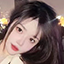

In [ ]:
xloader = get_xloader(config)
data_iter = iter(xloader)
x_fixed, _ = next(data_iter)

from torchvision.transforms import ToPILImage
to_img = ToPILImage()

# display tensor
to_img( denorm( x_fixed[0]  ) )

Loading the trained models from step 200000...
Finished preprocessing the CelebA dataset...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


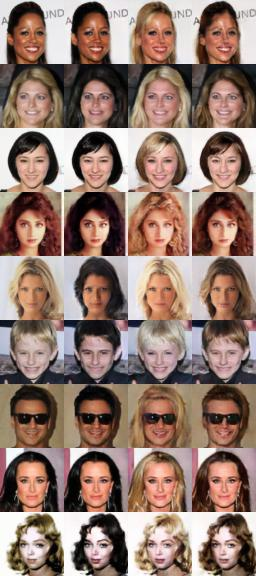

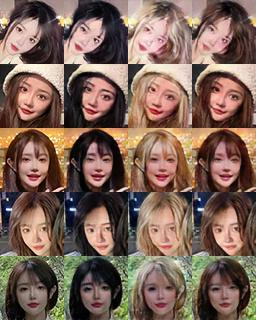

In [ ]:
from IPython.display import Image, display

# Choose the iteration number of the saved model (both G, D should be present)
################################################
##### TODO CODE HERE
##### Load the trained model
##### Also, load the data_loader in test mode

G, D = restore_model(200000, config['model_save_dir'])
G=G.to(config['device'])
D=D.to(config['device'])
data_loader = get_loader(config, mode='test')
xtdata_loader = get_xloader(config)
################################################

from itertools import chain

with torch.no_grad():
    for i, (x_real, c_org) in enumerate(chain(data_loader, xtdata_loader)):

        # Prepare input images and target domain labels.
        x_real = x_real.to(config['device'])
        c_trg_list = create_labels(c_org, config['c_dim'], config['selected_attributes'])

        # Translate images.
        x_fake_list = [x_real]
        for c_trg in c_trg_list:
            x_fake = G(x_real, c_trg)
            x_fake_list.append(x_fake)

        # Save the translated images.
        x_concat = torch.cat(x_fake_list, dim=3)
        result_path = os.path.join( config['result_dir'], '{}-images.jpg'.format(i+1) )
        save_image(denorm(x_concat.data.cpu()), result_path, nrow=1, padding=0)
        display(Image(filename=result_path))

### Q4.8 : (Bonus) Use other attributes and develop something cool. (20 points)

We have seen how to change hair style using GANs so far, but its possible to use any other attributes and develop something much cooler. You can use any other loss functions or the generator/discriminator architecture. Feel free to be creative and develop something cooler. 